# Algorithm for Data Processing


## Step 1: Read Data File

Import necessary packages. 

In [2]:
import pandas as pd #for working with dataframe
import numpy as np
from scipy import stats, integrate #will help in stats operation in histograms
import matplotlib.pyplot as plt #to plot the PE
import seaborn as sns #nice looking plots
%matplotlib inline
sns.set(color_codes=True)

##### Read the CSV file. Look at Data. 

In [2]:
df=pd.read_csv("FlatData.csv",encoding='latin1')
df.groupby('State').count() #summary of the data available

,BriefDescription,Length_miles,FunctionalClass,ImprovementType,InternalProjectID,main_ProjectInformation_ProjectID,County,TollType,ForecastYear,TrafficForecast,ForecastYearType,YearForecastProduced,ForecastMethodology,SegmentDescription,main_TrafficForecast_ProjectID,SegmentID,Year_ofObservation,Count
State,,,,,,,,,,,,,,,,,,
12.0,2066,1803,1923,0,1923,2066,2066,2066,2060,2066,2066,2060,2042,1188,2066,2066,2066,2066
27.0,38,38,38,0,38,38,38,38,38,38,38,38,38,32,38,38,38,38
28.0,2176,1565,0,0,2176,2176,1987,2176,2176,2176,2176,2176,2176,2176,2176,0,2176,2176
41.0,12411,0,12409,0,10677,12413,12413,12413,12413,12413,12413,12413,12413,12413,12413,0,12413,12413
58.0,0,0,457,0,457,457,457,457,457,457,457,457,457,0,457,0,457,457


## Step 2: Find a unique identifier for each project.
Some of the records in the database don't have any Internal Project ID number. We will need to analyse these differently. Create a new dataframe with only the rows that have a InternalProjectID.

In [3]:
df[df['InternalProjectID'].isnull()].groupby('State').count()

,BriefDescription,Length_miles,FunctionalClass,ImprovementType,InternalProjectID,main_ProjectInformation_ProjectID,County,TollType,ForecastYear,TrafficForecast,ForecastYearType,YearForecastProduced,ForecastMethodology,SegmentDescription,main_TrafficForecast_ProjectID,SegmentID,Year_ofObservation,Count
State,,,,,,,,,,,,,,,,,,
12.0,143,0,0,0,0,143,143,143,143,143,143,143,143,143,143,143,143,143
41.0,1734,0,1736,0,0,1736,1736,1736,1736,1736,1736,1736,1736,1736,1736,0,1736,1736


There are 143+1734 rows without any InternalProjectID. 
### Create a new dataframe with InternalProjectIDs.
#### flatdata_withID contains the rows that have project IDs.

In [4]:
flatdata_withID=df[df['InternalProjectID'].notnull()]
flatdata_withID #dataframe with IDs available.

,BriefDescription,Length_miles,FunctionalClass,ImprovementType,State,InternalProjectID,main_ProjectInformation_ProjectID,County,TollType,ForecastYear,TrafficForecast,ForecastYearType,YearForecastProduced,ForecastMethodology,SegmentDescription,main_TrafficForecast_ProjectID,SegmentID,Year_ofObservation,Count
0,IR71/US 30 interchange Modification,NaN,1.0,NaN,41.0,11378,41-2-11378-IR71/US 30 interchange Modification,Richland,1,2000.0,37190,1.0,1994.0,6,", , RIC7119.08",2,NaN,2000,42310
1,IR71/US 30 interchange Modification,NaN,1.0,NaN,41.0,11378,41-2-11378-IR71/US 30 interchange Modification,Richland,1,2020.0,45190,3.0,1994.0,6,", , RIC7119.08",2,NaN,2008,39760
2,IR71/US 30 interchange Modification,NaN,3.0,NaN,41.0,11378,41-3-11378-IR71/US 30 interchange Modification,Richland,1,2000.0,12920,1.0,1994.0,6,", , RIC3017.2",3,NaN,2000,15780
3,IR71/US 30 interchange Modification,NaN,3.0,NaN,41.0,11378,41-3-11378-IR71/US 30 interchange Modification,Richland,1,2020.0,17390,3.0,1994.0,6,", , RIC3017.2",3,NaN,2008,15630
4,IR71/US 30 interchange Modification,NaN,1.0,NaN,41.0,11378,41-4-11378-IR71/US 30 interchange Modification,Richland,1,2000.0,37820,1.0,1994.0,6,", , RIC7118.78",4,NaN,2000,42450
5,IR71/US 30 interchange Modification,NaN,1.0,NaN,41.0,11378,41-4-11378-IR71/US 30 interchange Modification,Richland,1,2020.0,46060,3.0,1994.0,6,", , RIC7118.78",4,NaN,2008,39290
6,IR71/US 30 interchange Modification,NaN,1.0,NaN,41.0,11378,41-5-11378-IR71/US 30 interchange Modification,Richland,1,2000.0,16430,1.0,1994.0,6,", , RIC3016.87",5,NaN,2000,16530
7,IR71/US 30 interchange Modification,NaN,1.0,NaN,41.0,11378,41-5-11378-IR71/US 30 interchange Modification,Richland,1,2020.0,22090,3.0,1994.0,6,", , RIC3016.87",5,NaN,2008,18210
8,TUS-0036-15.730,NaN,3.0,NaN,41.0,19055,41-6-19055-TUS-0036-15.730,Tuscarawas,1,2000.0,8990,1.0,1999.0,6,", , TUS3615.73",6,NaN,2000,9100
9,TUS-0036-15.730,NaN,3.0,NaN,41.0,19055,41-6-19055-TUS-0036-15.730,Tuscarawas,1,2020.0,11530,3.0,1999.0,6,", , TUS3615.73",6,NaN,2010,8960


#### flatdata_withoutID don't have any ID. will have to be cleaned up first differently.
In this flatdata_withoutID there are projects from Ohio and Florida D-4.
Ohio dataset has already been cleaned up. So we can exclude these altogether. The Florida D-4 data just needs minor tinkering in the brief-description column. We will take the second '-' sign and then take the characters before that to be the unique project ID.

In [5]:
flatdata_withoutID=df[df['InternalProjectID'].isnull()]
#flatdata_withoutID #dataframes without any ID, will have to analysed differently.

Exclude Ohio (State ID= 41) dataset. They don't actually indicate whether the actual counts are taken after the project was completed or not, that is why the acccuracy assessment may not be entirely correct. Looking at the Ohio dataset, we see that in the original excel worksheetthere is a column titled "Physical Works Completed On". If the Near Opening Year Count happens before this date, that means the count is taken when the project is not yet done. SO we have to exclude these values. Ohio dataset will have to be analysed separately.

### Ohio dataset cleaned up in a different way and then added to flatdata_withID

In [6]:
flatdata_withID=df[df['State']!=41.0]
#flatdata_withID

### Excluding Florida as well. As we are not sure if the traffic counts are taken after the project has been completed or not. 
Need to apply the same logic as before i.e. buffer of 3 years.

In [7]:
flatdata_withID=flatdata_withID[flatdata_withID['State']!=12.0]
#flatdata_withID

## Step 3: Apply filters to get useful rows

### Step 3.1: Year of Observation after project is opened
*aactual count* is to be taken in a year that is the same or later than the year of forecast. These are the rows that needs to be assessed. 


In [8]:
#flatdata_withID.describe()

In [9]:
flatdata_withID[flatdata_withID['Year_ofObservation']<flatdata_withID['ForecastYear']] #these projects are the ones where count is available before project has opened.

,BriefDescription,Length_miles,FunctionalClass,ImprovementType,State,InternalProjectID,main_ProjectInformation_ProjectID,County,TollType,ForecastYear,TrafficForecast,ForecastYearType,YearForecastProduced,ForecastMethodology,SegmentDescription,main_TrafficForecast_ProjectID,SegmentID,Year_ofObservation,Count
13416,TH 35 and Little Canada Road,NaN,NaN,NaN,28.0,TA-M286,28-7234-TA-M286-TH 35 and Little Canada Road,Ramsey,1,2005.0,3600,1.0,1981.0,1,", , , Little Canada RdWest of Co Rd CEB",7234,NaN,2004,20000
13417,TH 35 and Little Canada Road,NaN,NaN,NaN,28.0,TA-M286,28-7235-TA-M286-TH 35 and Little Canada Road,Ramsey,1,2005.0,3600,1.0,1981.0,1,", , , WB",7235,NaN,2004,20000
13418,TH 35 and Little Canada Road,NaN,NaN,NaN,28.0,TA-M286,28-7236-TA-M286-TH 35 and Little Canada Road,Ramsey,1,2005.0,6000,1.0,1981.0,1,", , , Little Canada RdBetween Co Rd C & Lakesh...",7236,NaN,2004,20000
13419,TH 35 and Little Canada Road,NaN,NaN,NaN,28.0,TA-M286,28-7237-TA-M286-TH 35 and Little Canada Road,Ramsey,1,2005.0,6000,1.0,1981.0,1,", , , WB",7237,NaN,2004,20000
13856,TH 494 from TH 12 (394) to TH 55,NaN,NaN,NaN,28.0,TA-M358,28-7674-TA-M358-TH 494 from TH 12 (394) to TH 55,Hennepin,1,2010.0,32800,1.0,1987.0,1,", , , I-494Between I-394NB",7674,NaN,1990,27000
13857,TH 494 from TH 12 (394) to TH 55,NaN,NaN,NaN,28.0,TA-M358,28-7675-TA-M358-TH 494 from TH 12 (394) to TH 55,Hennepin,1,2010.0,32800,1.0,1987.0,1,", , , SB",7675,NaN,1990,27000
14058,TH 55 From Western City Limits To TH61,NaN,NaN,NaN,28.0,TA-M300,28-7876-TA-M300-TH 55 From Western City Limits...,Dakota,1,2008.0,7390,1.0,1983.0,1,", , , TH 55West Of Pine StEB",7876,NaN,1986,14000
14059,TH 55 From Western City Limits To TH61,NaN,NaN,NaN,28.0,TA-M300,28-7877-TA-M300-TH 55 From Western City Limits...,Dakota,1,2008.0,7390,1.0,1983.0,1,", , , WB",7877,NaN,1986,14000
14060,TH 55 From Western City Limits To TH61,NaN,NaN,NaN,28.0,TA-M300,28-7878-TA-M300-TH 55 From Western City Limits...,Dakota,1,2008.0,5500,1.0,1983.0,1,", , , TH 55Between Pine StEB",7878,NaN,1986,14000
14061,TH 55 From Western City Limits To TH61,NaN,NaN,NaN,28.0,TA-M300,28-7879-TA-M300-TH 55 From Western City Limits...,Dakota,1,2008.0,5500,1.0,1983.0,1,", , , WB",7879,NaN,1986,14000


### Step 3.2: Filter out the rows where forecast year and year of observation is the same
This filter will give the rows whose forecasts we don't need to adjust.

In [10]:
flatdata_adjusted=flatdata_withID[flatdata_withID['Year_ofObservation']==flatdata_withID['ForecastYear']]

flatdata_adjusted

,BriefDescription,Length_miles,FunctionalClass,ImprovementType,State,InternalProjectID,main_ProjectInformation_ProjectID,County,TollType,ForecastYear,TrafficForecast,ForecastYearType,YearForecastProduced,ForecastMethodology,SegmentDescription,main_TrafficForecast_ProjectID,SegmentID,Year_ofObservation,Count
12413,NaN,NaN,3.0,NaN,58.0,1663,58-6231-1663-,Washington,1,2010.0,5300,1.0,2007.0,1,NaN,6231,NaN,2010,3700
12414,NaN,NaN,3.0,NaN,58.0,1663,58-6232-1663-,Washington,1,2010.0,7400,1.0,2007.0,1,NaN,6232,NaN,2010,5500
12415,NaN,NaN,3.0,NaN,58.0,1663,58-6233-1663-,Washington,1,2010.0,4150,1.0,2007.0,1,NaN,6233,NaN,2010,2800
12416,NaN,NaN,3.0,NaN,58.0,1663,58-6234-1663-,Washington,1,2010.0,3700,1.0,2007.0,1,NaN,6234,NaN,2010,2500
12417,NaN,NaN,3.0,NaN,58.0,1663,58-6235-1663-,Washington,1,2010.0,4500,1.0,2007.0,1,NaN,6235,NaN,2010,3500
12418,NaN,NaN,4.0,NaN,58.0,2015,58-6236-2015-,Washington,1,2007.0,18800,1.0,2005.0,1,NaN,6236,NaN,2007,14000
12419,NaN,NaN,4.0,NaN,58.0,2015,58-6237-2015-,Washington,1,2007.0,18200,1.0,2005.0,1,NaN,6237,NaN,2007,14700
12420,NaN,NaN,4.0,NaN,58.0,2015,58-6238-2015-,Washington,1,2007.0,19600,1.0,2005.0,1,NaN,6238,NaN,2007,16900
12421,NaN,NaN,0.0,NaN,58.0,2126,58-6239-2126-,Washington,1,2007.0,1300,1.0,2006.0,1,NaN,6239,NaN,2007,1900
12422,NaN,NaN,5.0,NaN,58.0,2486,58-6240-2486-,Washington,1,2010.0,1300,1.0,2007.0,1,NaN,6240,NaN,2010,1000


#### The rows where the Year of Observation is later than the forecast year will need to be adjusted.

In [11]:
flatdata_unadjusted=flatdata_withID[flatdata_withID['Year_ofObservation']>flatdata_withID['ForecastYear']]

In [12]:
flatdata_unadjusted.describe()

,Length_miles,FunctionalClass,ImprovementType,State,TollType,ForecastYear,TrafficForecast,ForecastYearType,YearForecastProduced,main_TrafficForecast_ProjectID,SegmentID,Year_ofObservation,Count
count,17.000000,5.0,0.0,47.000000,47.0,47.000000,47.000000,47.0,47.000000,47.000000,5.00000,47.000000,47.000000
mean,1.111765,3.0,NaN,27.893617,1.0,1994.255319,15658.404255,1.0,1982.404255,7397.170213,1.80000,2003.893617,10550.127660
std,0.731772,0.0,NaN,0.311661,0.0,10.855710,13044.373063,0.0,13.677432,808.232245,0.83666,10.104313,8431.493162
min,0.150000,3.0,NaN,27.000000,1.0,1975.000000,3300.000000,1.0,1963.000000,6731.000000,1.00000,1986.000000,2250.000000
25%,0.710000,3.0,NaN,28.000000,1.0,1986.000000,9517.500000,1.0,1974.000000,6742.500000,1.00000,1994.500000,7900.000000
50%,1.010000,3.0,NaN,28.000000,1.0,2000.000000,14100.000000,1.0,1985.000000,6754.000000,2.00000,2010.000000,7900.000000
75%,1.600000,3.0,NaN,28.000000,1.0,2000.000000,16350.000000,1.0,1985.000000,8071.500000,2.00000,2010.000000,11250.000000
max,2.500000,3.0,NaN,28.000000,1.0,2014.000000,66750.000000,1.0,2013.000000,9014.000000,3.00000,2016.000000,42874.000000


### Step 3.3: Filter out by Forecast Year Type
Since we are only looking at Opening Year forecasts (Year Type ID= 1), filter out the previous dataset by Type 1.

In [13]:
flatdata_adjusted=flatdata_adjusted[flatdata_adjusted['ForecastYearType']==1.0]
flatdata_adjusted

,BriefDescription,Length_miles,FunctionalClass,ImprovementType,State,InternalProjectID,main_ProjectInformation_ProjectID,County,TollType,ForecastYear,TrafficForecast,ForecastYearType,YearForecastProduced,ForecastMethodology,SegmentDescription,main_TrafficForecast_ProjectID,SegmentID,Year_ofObservation,Count
12413,NaN,NaN,3.0,NaN,58.0,1663,58-6231-1663-,Washington,1,2010.0,5300,1.0,2007.0,1,NaN,6231,NaN,2010,3700
12414,NaN,NaN,3.0,NaN,58.0,1663,58-6232-1663-,Washington,1,2010.0,7400,1.0,2007.0,1,NaN,6232,NaN,2010,5500
12415,NaN,NaN,3.0,NaN,58.0,1663,58-6233-1663-,Washington,1,2010.0,4150,1.0,2007.0,1,NaN,6233,NaN,2010,2800
12416,NaN,NaN,3.0,NaN,58.0,1663,58-6234-1663-,Washington,1,2010.0,3700,1.0,2007.0,1,NaN,6234,NaN,2010,2500
12417,NaN,NaN,3.0,NaN,58.0,1663,58-6235-1663-,Washington,1,2010.0,4500,1.0,2007.0,1,NaN,6235,NaN,2010,3500
12418,NaN,NaN,4.0,NaN,58.0,2015,58-6236-2015-,Washington,1,2007.0,18800,1.0,2005.0,1,NaN,6236,NaN,2007,14000
12419,NaN,NaN,4.0,NaN,58.0,2015,58-6237-2015-,Washington,1,2007.0,18200,1.0,2005.0,1,NaN,6237,NaN,2007,14700
12420,NaN,NaN,4.0,NaN,58.0,2015,58-6238-2015-,Washington,1,2007.0,19600,1.0,2005.0,1,NaN,6238,NaN,2007,16900
12421,NaN,NaN,0.0,NaN,58.0,2126,58-6239-2126-,Washington,1,2007.0,1300,1.0,2006.0,1,NaN,6239,NaN,2007,1900
12422,NaN,NaN,5.0,NaN,58.0,2486,58-6240-2486-,Washington,1,2010.0,1300,1.0,2007.0,1,NaN,6240,NaN,2010,1000


In [14]:
flatdata_adjusted=flatdata_adjusted.assign(AdjustedForecast=flatdata_withID['TrafficForecast'])
flatdata_adjusted

,BriefDescription,Length_miles,FunctionalClass,ImprovementType,State,InternalProjectID,main_ProjectInformation_ProjectID,County,TollType,ForecastYear,TrafficForecast,ForecastYearType,YearForecastProduced,ForecastMethodology,SegmentDescription,main_TrafficForecast_ProjectID,SegmentID,Year_ofObservation,Count,AdjustedForecast
12413,NaN,NaN,3.0,NaN,58.0,1663,58-6231-1663-,Washington,1,2010.0,5300,1.0,2007.0,1,NaN,6231,NaN,2010,3700,5300
12414,NaN,NaN,3.0,NaN,58.0,1663,58-6232-1663-,Washington,1,2010.0,7400,1.0,2007.0,1,NaN,6232,NaN,2010,5500,7400
12415,NaN,NaN,3.0,NaN,58.0,1663,58-6233-1663-,Washington,1,2010.0,4150,1.0,2007.0,1,NaN,6233,NaN,2010,2800,4150
12416,NaN,NaN,3.0,NaN,58.0,1663,58-6234-1663-,Washington,1,2010.0,3700,1.0,2007.0,1,NaN,6234,NaN,2010,2500,3700
12417,NaN,NaN,3.0,NaN,58.0,1663,58-6235-1663-,Washington,1,2010.0,4500,1.0,2007.0,1,NaN,6235,NaN,2010,3500,4500
12418,NaN,NaN,4.0,NaN,58.0,2015,58-6236-2015-,Washington,1,2007.0,18800,1.0,2005.0,1,NaN,6236,NaN,2007,14000,18800
12419,NaN,NaN,4.0,NaN,58.0,2015,58-6237-2015-,Washington,1,2007.0,18200,1.0,2005.0,1,NaN,6237,NaN,2007,14700,18200
12420,NaN,NaN,4.0,NaN,58.0,2015,58-6238-2015-,Washington,1,2007.0,19600,1.0,2005.0,1,NaN,6238,NaN,2007,16900,19600
12421,NaN,NaN,0.0,NaN,58.0,2126,58-6239-2126-,Washington,1,2007.0,1300,1.0,2006.0,1,NaN,6239,NaN,2007,1900,1300
12422,NaN,NaN,5.0,NaN,58.0,2486,58-6240-2486-,Washington,1,2010.0,1300,1.0,2007.0,1,NaN,6240,NaN,2010,1000,1300


In [15]:
ohio_adjusted=pd.read_csv('Ohio_CleanedDataset.csv')
ohio_adjusted

,InternalProjectID,YearForecastProduced,ForecastYear,TrafficForecast,TollType,FunctionalClass,ForecastMethodology,ImprovementType,State,Year_ofObservation,Count,AdjustedForecast
0,75086,2002,2003,27070,1,1,6,1,41,2008,28740,28897.500000
1,25377,2002,2003,11540,1,3,6,12,41,2003,11000,11540.000000
2,25377,2002,2003,10740,1,3,6,12,41,2003,11670,10740.000000
3,25377,2002,2003,1020,1,5,6,12,41,2004,1440,1037.500000
4,16964,2002,2003,62530,1,1,6,12,41,2003,67020,62530.000000
5,22788,2002,2003,46460,1,1,6,12,41,2003,34920,46460.000000
6,20996,2002,2004,20540,1,1,6,12,41,2010,17970,23498.000000
7,21582,2002,2004,6550,1,3,6,1,41,2005,6090,6598.333333
8,24316,2002,2004,7280,1,3,6,1,41,2009,6470,7630.000000
9,24316,2002,2004,12170,1,3,6,1,41,2009,10150,12755.000000


In [16]:
florida_adjusted=pd.read_csv('florida_final.csv')
florida_adjusted

,InternalProjectID,BriefDescription,Length_miles,FunctionalClass,ImprovementType,State,main_ProjectInformation_ProjectID,County,TollType,ForecastYear,...,ForecastYearType,YearForecastProduced,ForecastMethodology,SegmentDescription,main_TrafficForecast_ProjectID,SegmentID,Year_ofObservation,Count,Year,AdjustedForecast
0,237506-2,Replacement of Medium Level Bridge over Banana...,0.600,3,1.0,12,12-9018-237506-2-Replacement of Medium Level B...,Brevard,1,2003,...,1,2001.0,1.0,M.P 13.600 to M.P. 14.200,9018,1,2003,35000,2004,32000.0
1,237506-2,Replacement of Medium Level Bridge over Banana...,0.600,3,1.0,12,12-9337-237506-2-Replacement of Medium Level B...,Brevard,1,2003,...,1,2001.0,1.0,M.P 13.600 to M.P. 14.200,9337,1,2003,35000,2004,32000.0
2,237550-1,S.R. 5/US 1 Resurfacing Project in Brevard Cou...,2.624,3,1.0,12,12-9019-237550-1-S.R. 5/US 1 Resurfacing Proje...,Brevard,1,2004,...,1,2004.0,1.0,M.P 7.300 to M.P 9.924,9019,1,2004,33000,2005,39300.0
3,237550-1,S.R. 5/US 1 Resurfacing Project in Brevard Cou...,2.624,3,1.0,12,12-9338-237550-1-S.R. 5/US 1 Resurfacing Proje...,Brevard,1,2004,...,1,2004.0,1.0,M.P 7.300 to M.P 9.924,9338,1,2004,33000,2005,39300.0
4,237565-1,SR 513 Corridor Improvement Project (M.P 1.913...,2.432,4,1.0,12,12-9020-237565-1-SR 513 Corridor Improvement P...,Brevard,1,2010,...,1,2004.0,1.0,M.P 1.913 to M.P 5.059,9020,1,2010,13500,2011,18300.0
5,237565-1,SR 513 Corridor Improvement Project (M.P 1.913...,2.432,4,1.0,12,12-9339-237565-1-SR 513 Corridor Improvement P...,Brevard,1,2010,...,1,2004.0,1.0,M.P 1.913 to M.P 5.059,9339,1,2010,13500,2011,18300.0
6,237567-1,SR 501 Resurfacing Project on SR 501 from CR 5...,1.478,3,1.0,12,12-9021-237567-1-SR 501 Resurfacing Project on...,Brevard,1,2007,...,1,2007.0,1.0,M.P 1.193 to Michigan Boulevard,9021,1,2007,21000,2008,24300.0
7,237567-1,SR 501 Resurfacing Project on SR 501 from CR 5...,1.478,3,1.0,12,12-9021-237567-1-SR 501 Resurfacing Project on...,Brevard,1,2007,...,1,2007.0,1.0,M.P 1.193 to Michigan Boulevard,9021,1,2007,21000,2008,24300.0
8,237567-1,SR 501 Resurfacing Project on SR 501 from CR 5...,1.478,3,1.0,12,12-9021-237567-1-SR 501 Resurfacing Project on...,Brevard,1,2007,...,1,2007.0,1.0,M.P 1.193 to Michigan Boulevard,9021,1,2007,23000,2008,24300.0
9,237567-1,SR 501 Resurfacing Project on SR 501 from CR 5...,1.478,3,1.0,12,12-9021-237567-1-SR 501 Resurfacing Project on...,Brevard,1,2007,...,1,2007.0,1.0,M.P 1.193 to Michigan Boulevard,9021,1,2007,23000,2008,24300.0


In [17]:
florida_adjusted=florida_adjusted.drop(['Year_ofObservation'],axis=1)
florida_adjusted

,InternalProjectID,BriefDescription,Length_miles,FunctionalClass,ImprovementType,State,main_ProjectInformation_ProjectID,County,TollType,ForecastYear,TrafficForecast,ForecastYearType,YearForecastProduced,ForecastMethodology,SegmentDescription,main_TrafficForecast_ProjectID,SegmentID,Count,Year,AdjustedForecast
0,237506-2,Replacement of Medium Level Bridge over Banana...,0.600,3,1.0,12,12-9018-237506-2-Replacement of Medium Level B...,Brevard,1,2003,32000,1,2001.0,1.0,M.P 13.600 to M.P. 14.200,9018,1,35000,2004,32000.0
1,237506-2,Replacement of Medium Level Bridge over Banana...,0.600,3,1.0,12,12-9337-237506-2-Replacement of Medium Level B...,Brevard,1,2003,32000,1,2001.0,1.0,M.P 13.600 to M.P. 14.200,9337,1,35000,2004,32000.0
2,237550-1,S.R. 5/US 1 Resurfacing Project in Brevard Cou...,2.624,3,1.0,12,12-9019-237550-1-S.R. 5/US 1 Resurfacing Proje...,Brevard,1,2004,39300,1,2004.0,1.0,M.P 7.300 to M.P 9.924,9019,1,33000,2005,39300.0
3,237550-1,S.R. 5/US 1 Resurfacing Project in Brevard Cou...,2.624,3,1.0,12,12-9338-237550-1-S.R. 5/US 1 Resurfacing Proje...,Brevard,1,2004,39300,1,2004.0,1.0,M.P 7.300 to M.P 9.924,9338,1,33000,2005,39300.0
4,237565-1,SR 513 Corridor Improvement Project (M.P 1.913...,2.432,4,1.0,12,12-9020-237565-1-SR 513 Corridor Improvement P...,Brevard,1,2010,18300,1,2004.0,1.0,M.P 1.913 to M.P 5.059,9020,1,13500,2011,18300.0
5,237565-1,SR 513 Corridor Improvement Project (M.P 1.913...,2.432,4,1.0,12,12-9339-237565-1-SR 513 Corridor Improvement P...,Brevard,1,2010,18300,1,2004.0,1.0,M.P 1.913 to M.P 5.059,9339,1,13500,2011,18300.0
6,237567-1,SR 501 Resurfacing Project on SR 501 from CR 5...,1.478,3,1.0,12,12-9021-237567-1-SR 501 Resurfacing Project on...,Brevard,1,2007,24300,1,2007.0,1.0,M.P 1.193 to Michigan Boulevard,9021,1,21000,2008,24300.0
7,237567-1,SR 501 Resurfacing Project on SR 501 from CR 5...,1.478,3,1.0,12,12-9021-237567-1-SR 501 Resurfacing Project on...,Brevard,1,2007,24300,1,2007.0,1.0,M.P 1.193 to Michigan Boulevard,9021,1,21000,2008,24300.0
8,237567-1,SR 501 Resurfacing Project on SR 501 from CR 5...,1.478,3,1.0,12,12-9021-237567-1-SR 501 Resurfacing Project on...,Brevard,1,2007,24300,1,2007.0,1.0,M.P 1.193 to Michigan Boulevard,9021,1,23000,2008,24300.0
9,237567-1,SR 501 Resurfacing Project on SR 501 from CR 5...,1.478,3,1.0,12,12-9021-237567-1-SR 501 Resurfacing Project on...,Brevard,1,2007,24300,1,2007.0,1.0,M.P 1.193 to Michigan Boulevard,9021,1,23000,2008,24300.0


In [18]:
florida_adjusted=florida_adjusted.rename(index=str,columns={'Year':'Year_ofObservation'})
florida_adjusted

,InternalProjectID,BriefDescription,Length_miles,FunctionalClass,ImprovementType,State,main_ProjectInformation_ProjectID,County,TollType,ForecastYear,TrafficForecast,ForecastYearType,YearForecastProduced,ForecastMethodology,SegmentDescription,main_TrafficForecast_ProjectID,SegmentID,Count,Year_ofObservation,AdjustedForecast
0,237506-2,Replacement of Medium Level Bridge over Banana...,0.600,3,1.0,12,12-9018-237506-2-Replacement of Medium Level B...,Brevard,1,2003,32000,1,2001.0,1.0,M.P 13.600 to M.P. 14.200,9018,1,35000,2004,32000.0
1,237506-2,Replacement of Medium Level Bridge over Banana...,0.600,3,1.0,12,12-9337-237506-2-Replacement of Medium Level B...,Brevard,1,2003,32000,1,2001.0,1.0,M.P 13.600 to M.P. 14.200,9337,1,35000,2004,32000.0
2,237550-1,S.R. 5/US 1 Resurfacing Project in Brevard Cou...,2.624,3,1.0,12,12-9019-237550-1-S.R. 5/US 1 Resurfacing Proje...,Brevard,1,2004,39300,1,2004.0,1.0,M.P 7.300 to M.P 9.924,9019,1,33000,2005,39300.0
3,237550-1,S.R. 5/US 1 Resurfacing Project in Brevard Cou...,2.624,3,1.0,12,12-9338-237550-1-S.R. 5/US 1 Resurfacing Proje...,Brevard,1,2004,39300,1,2004.0,1.0,M.P 7.300 to M.P 9.924,9338,1,33000,2005,39300.0
4,237565-1,SR 513 Corridor Improvement Project (M.P 1.913...,2.432,4,1.0,12,12-9020-237565-1-SR 513 Corridor Improvement P...,Brevard,1,2010,18300,1,2004.0,1.0,M.P 1.913 to M.P 5.059,9020,1,13500,2011,18300.0
5,237565-1,SR 513 Corridor Improvement Project (M.P 1.913...,2.432,4,1.0,12,12-9339-237565-1-SR 513 Corridor Improvement P...,Brevard,1,2010,18300,1,2004.0,1.0,M.P 1.913 to M.P 5.059,9339,1,13500,2011,18300.0
6,237567-1,SR 501 Resurfacing Project on SR 501 from CR 5...,1.478,3,1.0,12,12-9021-237567-1-SR 501 Resurfacing Project on...,Brevard,1,2007,24300,1,2007.0,1.0,M.P 1.193 to Michigan Boulevard,9021,1,21000,2008,24300.0
7,237567-1,SR 501 Resurfacing Project on SR 501 from CR 5...,1.478,3,1.0,12,12-9021-237567-1-SR 501 Resurfacing Project on...,Brevard,1,2007,24300,1,2007.0,1.0,M.P 1.193 to Michigan Boulevard,9021,1,21000,2008,24300.0
8,237567-1,SR 501 Resurfacing Project on SR 501 from CR 5...,1.478,3,1.0,12,12-9021-237567-1-SR 501 Resurfacing Project on...,Brevard,1,2007,24300,1,2007.0,1.0,M.P 1.193 to Michigan Boulevard,9021,1,23000,2008,24300.0
9,237567-1,SR 501 Resurfacing Project on SR 501 from CR 5...,1.478,3,1.0,12,12-9021-237567-1-SR 501 Resurfacing Project on...,Brevard,1,2007,24300,1,2007.0,1.0,M.P 1.193 to Michigan Boulevard,9021,1,23000,2008,24300.0


In [19]:
florida_adjusted.describe()

,Length_miles,FunctionalClass,ImprovementType,State,TollType,ForecastYear,TrafficForecast,ForecastYearType,YearForecastProduced,ForecastMethodology,main_TrafficForecast_ProjectID,SegmentID,Count,Year_ofObservation,AdjustedForecast
count,1706.000000,1844.000000,1842.000000,1844.0,1844.000000,1844.000000,1844.000000,1844.0,1836.000000,1818.000000,1844.000000,1844.000000,1844.000000,1844.000000,1844.000000
mean,7.396385,3.044469,1.719870,12.0,1.091106,2007.767896,27997.022777,1.0,2004.931373,3.727173,9339.087852,1.716920,27290.200651,2008.985900,28227.137202
std,6.339706,0.560188,1.711934,0.0,0.287838,2.498036,16360.191102,0.0,2.217266,1.605693,187.245504,0.845733,17279.943463,2.561626,16314.837247
min,0.001000,1.000000,1.000000,12.0,1.000000,2002.000000,1500.000000,1.0,2001.000000,1.000000,9018.000000,1.000000,1450.000000,2004.000000,1500.000000
25%,2.582000,3.000000,1.000000,12.0,1.000000,2006.000000,15200.000000,1.0,2003.000000,4.000000,9168.000000,1.000000,14400.000000,2007.000000,15700.000000
50%,5.680000,3.000000,1.000000,12.0,1.000000,2008.000000,26400.000000,1.0,2005.000000,4.000000,9342.500000,1.500000,25500.000000,2009.000000,26400.000000
75%,10.930000,3.000000,1.000000,12.0,1.000000,2010.000000,37800.000000,1.0,2007.000000,5.000000,9491.250000,2.000000,36500.000000,2011.000000,37800.000000
max,23.285999,5.000000,12.000000,12.0,2.000000,2012.000000,148500.000000,1.0,2010.000000,5.000000,9660.000000,4.000000,160000.000000,2013.000000,148500.000000


In [20]:
pd.options.display.max_columns=30

In [21]:
flatdata_adjusted2=flatdata_adjusted.append(ohio_adjusted,ignore_index=True)
flatdata_adjusted2

,AdjustedForecast,BriefDescription,Count,County,ForecastMethodology,ForecastYear,ForecastYearType,FunctionalClass,ImprovementType,InternalProjectID,Length_miles,SegmentDescription,SegmentID,State,TollType,TrafficForecast,YearForecastProduced,Year_ofObservation,main_ProjectInformation_ProjectID,main_TrafficForecast_ProjectID
0,5300.0,NaN,3700,Washington,1,2010.0,1.0,3.0,NaN,1663,NaN,NaN,NaN,58.0,1,5300,2007.0,2010,58-6231-1663-,6231.0
1,7400.0,NaN,5500,Washington,1,2010.0,1.0,3.0,NaN,1663,NaN,NaN,NaN,58.0,1,7400,2007.0,2010,58-6232-1663-,6232.0
2,4150.0,NaN,2800,Washington,1,2010.0,1.0,3.0,NaN,1663,NaN,NaN,NaN,58.0,1,4150,2007.0,2010,58-6233-1663-,6233.0
3,3700.0,NaN,2500,Washington,1,2010.0,1.0,3.0,NaN,1663,NaN,NaN,NaN,58.0,1,3700,2007.0,2010,58-6234-1663-,6234.0
4,4500.0,NaN,3500,Washington,1,2010.0,1.0,3.0,NaN,1663,NaN,NaN,NaN,58.0,1,4500,2007.0,2010,58-6235-1663-,6235.0
5,18800.0,NaN,14000,Washington,1,2007.0,1.0,4.0,NaN,2015,NaN,NaN,NaN,58.0,1,18800,2005.0,2007,58-6236-2015-,6236.0
6,18200.0,NaN,14700,Washington,1,2007.0,1.0,4.0,NaN,2015,NaN,NaN,NaN,58.0,1,18200,2005.0,2007,58-6237-2015-,6237.0
7,19600.0,NaN,16900,Washington,1,2007.0,1.0,4.0,NaN,2015,NaN,NaN,NaN,58.0,1,19600,2005.0,2007,58-6238-2015-,6238.0
8,1300.0,NaN,1900,Washington,1,2007.0,1.0,0.0,NaN,2126,NaN,NaN,NaN,58.0,1,1300,2006.0,2007,58-6239-2126-,6239.0
9,1300.0,NaN,1000,Washington,1,2010.0,1.0,5.0,NaN,2486,NaN,NaN,NaN,58.0,1,1300,2007.0,2010,58-6240-2486-,6240.0


In [22]:
flatdata_adjusted3=flatdata_adjusted2.append(florida_adjusted,ignore_index=True)
flatdata_adjusted3

,AdjustedForecast,BriefDescription,Count,County,ForecastMethodology,ForecastYear,ForecastYearType,FunctionalClass,ImprovementType,InternalProjectID,Length_miles,SegmentDescription,SegmentID,State,TollType,TrafficForecast,YearForecastProduced,Year_ofObservation,main_ProjectInformation_ProjectID,main_TrafficForecast_ProjectID
0,5300.0,NaN,3700,Washington,1,2010.0,1.0,3.0,NaN,1663,NaN,NaN,NaN,58.0,1,5300,2007.0,2010,58-6231-1663-,6231.0
1,7400.0,NaN,5500,Washington,1,2010.0,1.0,3.0,NaN,1663,NaN,NaN,NaN,58.0,1,7400,2007.0,2010,58-6232-1663-,6232.0
2,4150.0,NaN,2800,Washington,1,2010.0,1.0,3.0,NaN,1663,NaN,NaN,NaN,58.0,1,4150,2007.0,2010,58-6233-1663-,6233.0
3,3700.0,NaN,2500,Washington,1,2010.0,1.0,3.0,NaN,1663,NaN,NaN,NaN,58.0,1,3700,2007.0,2010,58-6234-1663-,6234.0
4,4500.0,NaN,3500,Washington,1,2010.0,1.0,3.0,NaN,1663,NaN,NaN,NaN,58.0,1,4500,2007.0,2010,58-6235-1663-,6235.0
5,18800.0,NaN,14000,Washington,1,2007.0,1.0,4.0,NaN,2015,NaN,NaN,NaN,58.0,1,18800,2005.0,2007,58-6236-2015-,6236.0
6,18200.0,NaN,14700,Washington,1,2007.0,1.0,4.0,NaN,2015,NaN,NaN,NaN,58.0,1,18200,2005.0,2007,58-6237-2015-,6237.0
7,19600.0,NaN,16900,Washington,1,2007.0,1.0,4.0,NaN,2015,NaN,NaN,NaN,58.0,1,19600,2005.0,2007,58-6238-2015-,6238.0
8,1300.0,NaN,1900,Washington,1,2007.0,1.0,0.0,NaN,2126,NaN,NaN,NaN,58.0,1,1300,2006.0,2007,58-6239-2126-,6239.0
9,1300.0,NaN,1000,Washington,1,2010.0,1.0,5.0,NaN,2486,NaN,NaN,NaN,58.0,1,1300,2007.0,2010,58-6240-2486-,6240.0


In [23]:
flatdata_adjusted3[flatdata_adjusted3['Count'].isnull()]

,AdjustedForecast,BriefDescription,Count,County,ForecastMethodology,ForecastYear,ForecastYearType,FunctionalClass,ImprovementType,InternalProjectID,Length_miles,SegmentDescription,SegmentID,State,TollType,TrafficForecast,YearForecastProduced,Year_ofObservation,main_ProjectInformation_ProjectID,main_TrafficForecast_ProjectID


In [35]:
flatdata_adjusted3.to_csv('flatdata_adjusted3.csv')

# Analysis
Analysis are to be done on two different levels:
1. Segment Level and
2. Project Level
For segment level analysis, each row is to be considered a separate entity and the accuracy will be offset by a weight factor. This weight factor will ensure that we are not counting the same error 


In [36]:
flatdata_adjusted=pd.read_csv('flatdata_adjusted3.csv')
flatdata_adjusted

,AdjustedForecast,BriefDescription,Count,County,ForecastMethodology,ForecastYear,ForecastYearType,FunctionalClass,ImprovementType,InternalProjectID,Length_miles,SegmentDescription,SegmentID,State,TollType,TrafficForecast,YearForecastProduced,Year_ofObservation,main_ProjectInformation_ProjectID,main_TrafficForecast_ProjectID
0,5300.0,NaN,3700,Washington,1,2010,1.0,3.0,NaN,1663,NaN,NaN,NaN,58,1,5300,2007.0,2010,58-6231-1663-,6231.0
1,7400.0,NaN,5500,Washington,1,2010,1.0,3.0,NaN,1663,NaN,NaN,NaN,58,1,7400,2007.0,2010,58-6232-1663-,6232.0
2,4150.0,NaN,2800,Washington,1,2010,1.0,3.0,NaN,1663,NaN,NaN,NaN,58,1,4150,2007.0,2010,58-6233-1663-,6233.0
3,3700.0,NaN,2500,Washington,1,2010,1.0,3.0,NaN,1663,NaN,NaN,NaN,58,1,3700,2007.0,2010,58-6234-1663-,6234.0
4,4500.0,NaN,3500,Washington,1,2010,1.0,3.0,NaN,1663,NaN,NaN,NaN,58,1,4500,2007.0,2010,58-6235-1663-,6235.0
5,18800.0,NaN,14000,Washington,1,2007,1.0,4.0,NaN,2015,NaN,NaN,NaN,58,1,18800,2005.0,2007,58-6236-2015-,6236.0
6,18200.0,NaN,14700,Washington,1,2007,1.0,4.0,NaN,2015,NaN,NaN,NaN,58,1,18200,2005.0,2007,58-6237-2015-,6237.0
7,19600.0,NaN,16900,Washington,1,2007,1.0,4.0,NaN,2015,NaN,NaN,NaN,58,1,19600,2005.0,2007,58-6238-2015-,6238.0
8,1300.0,NaN,1900,Washington,1,2007,1.0,0.0,NaN,2126,NaN,NaN,NaN,58,1,1300,2006.0,2007,58-6239-2126-,6239.0
9,1300.0,NaN,1000,Washington,1,2010,1.0,5.0,NaN,2486,NaN,NaN,NaN,58,1,1300,2007.0,2010,58-6240-2486-,6240.0


In [84]:
#project_weight = flatdata['InternalProjectID'].groupby(flatdata['InternalProjectID']).count().to_frame(name='n')
#flatdata_adjusted= pd.merge(flatdata,project_weight, left_on='InternalProjectID',right_index=True)
#flatdata_adjusted

In [24]:
flatdata_adjusted=flatdata_adjusted3
flatdata_adjusted

,AdjustedForecast,BriefDescription,Count,County,ForecastMethodology,ForecastYear,ForecastYearType,FunctionalClass,ImprovementType,InternalProjectID,Length_miles,SegmentDescription,SegmentID,State,TollType,TrafficForecast,YearForecastProduced,Year_ofObservation,main_ProjectInformation_ProjectID,main_TrafficForecast_ProjectID
0,5300.0,NaN,3700,Washington,1,2010.0,1.0,3.0,NaN,1663,NaN,NaN,NaN,58.0,1,5300,2007.0,2010,58-6231-1663-,6231.0
1,7400.0,NaN,5500,Washington,1,2010.0,1.0,3.0,NaN,1663,NaN,NaN,NaN,58.0,1,7400,2007.0,2010,58-6232-1663-,6232.0
2,4150.0,NaN,2800,Washington,1,2010.0,1.0,3.0,NaN,1663,NaN,NaN,NaN,58.0,1,4150,2007.0,2010,58-6233-1663-,6233.0
3,3700.0,NaN,2500,Washington,1,2010.0,1.0,3.0,NaN,1663,NaN,NaN,NaN,58.0,1,3700,2007.0,2010,58-6234-1663-,6234.0
4,4500.0,NaN,3500,Washington,1,2010.0,1.0,3.0,NaN,1663,NaN,NaN,NaN,58.0,1,4500,2007.0,2010,58-6235-1663-,6235.0
5,18800.0,NaN,14000,Washington,1,2007.0,1.0,4.0,NaN,2015,NaN,NaN,NaN,58.0,1,18800,2005.0,2007,58-6236-2015-,6236.0
6,18200.0,NaN,14700,Washington,1,2007.0,1.0,4.0,NaN,2015,NaN,NaN,NaN,58.0,1,18200,2005.0,2007,58-6237-2015-,6237.0
7,19600.0,NaN,16900,Washington,1,2007.0,1.0,4.0,NaN,2015,NaN,NaN,NaN,58.0,1,19600,2005.0,2007,58-6238-2015-,6238.0
8,1300.0,NaN,1900,Washington,1,2007.0,1.0,0.0,NaN,2126,NaN,NaN,NaN,58.0,1,1300,2006.0,2007,58-6239-2126-,6239.0
9,1300.0,NaN,1000,Washington,1,2010.0,1.0,5.0,NaN,2486,NaN,NaN,NaN,58.0,1,1300,2007.0,2010,58-6240-2486-,6240.0


In [55]:
#flatdata_adjusted['Count']=flatdata_adjusted['Count'].astype('float')

# Segment Level Accuracy

## Step 5: Create New Columns for Error, Percent Error, Weighted Percent Error and Absolute Percent Error

#### Error=Actual Traffic-Forecasted Traffic

In [25]:
pd.options.display.max_columns=40

In [26]:
flatdata_adjusted=flatdata_adjusted.assign(Error=flatdata_adjusted['Count']-flatdata_adjusted['AdjustedForecast'])
flatdata_adjusted

,AdjustedForecast,BriefDescription,Count,County,ForecastMethodology,ForecastYear,ForecastYearType,FunctionalClass,ImprovementType,InternalProjectID,Length_miles,SegmentDescription,SegmentID,State,TollType,TrafficForecast,YearForecastProduced,Year_ofObservation,main_ProjectInformation_ProjectID,main_TrafficForecast_ProjectID,Error
0,5300.0,NaN,3700,Washington,1,2010.0,1.0,3.0,NaN,1663,NaN,NaN,NaN,58.0,1,5300,2007.0,2010,58-6231-1663-,6231.0,-1600.0
1,7400.0,NaN,5500,Washington,1,2010.0,1.0,3.0,NaN,1663,NaN,NaN,NaN,58.0,1,7400,2007.0,2010,58-6232-1663-,6232.0,-1900.0
2,4150.0,NaN,2800,Washington,1,2010.0,1.0,3.0,NaN,1663,NaN,NaN,NaN,58.0,1,4150,2007.0,2010,58-6233-1663-,6233.0,-1350.0
3,3700.0,NaN,2500,Washington,1,2010.0,1.0,3.0,NaN,1663,NaN,NaN,NaN,58.0,1,3700,2007.0,2010,58-6234-1663-,6234.0,-1200.0
4,4500.0,NaN,3500,Washington,1,2010.0,1.0,3.0,NaN,1663,NaN,NaN,NaN,58.0,1,4500,2007.0,2010,58-6235-1663-,6235.0,-1000.0
5,18800.0,NaN,14000,Washington,1,2007.0,1.0,4.0,NaN,2015,NaN,NaN,NaN,58.0,1,18800,2005.0,2007,58-6236-2015-,6236.0,-4800.0
6,18200.0,NaN,14700,Washington,1,2007.0,1.0,4.0,NaN,2015,NaN,NaN,NaN,58.0,1,18200,2005.0,2007,58-6237-2015-,6237.0,-3500.0
7,19600.0,NaN,16900,Washington,1,2007.0,1.0,4.0,NaN,2015,NaN,NaN,NaN,58.0,1,19600,2005.0,2007,58-6238-2015-,6238.0,-2700.0
8,1300.0,NaN,1900,Washington,1,2007.0,1.0,0.0,NaN,2126,NaN,NaN,NaN,58.0,1,1300,2006.0,2007,58-6239-2126-,6239.0,600.0
9,1300.0,NaN,1000,Washington,1,2010.0,1.0,5.0,NaN,2486,NaN,NaN,NaN,58.0,1,1300,2007.0,2010,58-6240-2486-,6240.0,-300.0


#### Percent Error= 100xError/Forecasted Traffic. 
Logic is when the forecast is made, uncertainty can be expressed in terms of the forecast value since the observed value is unknown when forecasting is done.

In [27]:
flatdata_adjusted=flatdata_adjusted.assign(PercentError=100*flatdata_adjusted['Error']/flatdata_adjusted['AdjustedForecast'],
                                          ) 

In [28]:
flatdata_adjusted

,AdjustedForecast,BriefDescription,Count,County,ForecastMethodology,ForecastYear,ForecastYearType,FunctionalClass,ImprovementType,InternalProjectID,Length_miles,SegmentDescription,SegmentID,State,TollType,TrafficForecast,YearForecastProduced,Year_ofObservation,main_ProjectInformation_ProjectID,main_TrafficForecast_ProjectID,Error,PercentError
0,5300.0,NaN,3700,Washington,1,2010.0,1.0,3.0,NaN,1663,NaN,NaN,NaN,58.0,1,5300,2007.0,2010,58-6231-1663-,6231.0,-1600.0,-30.188679
1,7400.0,NaN,5500,Washington,1,2010.0,1.0,3.0,NaN,1663,NaN,NaN,NaN,58.0,1,7400,2007.0,2010,58-6232-1663-,6232.0,-1900.0,-25.675676
2,4150.0,NaN,2800,Washington,1,2010.0,1.0,3.0,NaN,1663,NaN,NaN,NaN,58.0,1,4150,2007.0,2010,58-6233-1663-,6233.0,-1350.0,-32.530120
3,3700.0,NaN,2500,Washington,1,2010.0,1.0,3.0,NaN,1663,NaN,NaN,NaN,58.0,1,3700,2007.0,2010,58-6234-1663-,6234.0,-1200.0,-32.432432
4,4500.0,NaN,3500,Washington,1,2010.0,1.0,3.0,NaN,1663,NaN,NaN,NaN,58.0,1,4500,2007.0,2010,58-6235-1663-,6235.0,-1000.0,-22.222222
5,18800.0,NaN,14000,Washington,1,2007.0,1.0,4.0,NaN,2015,NaN,NaN,NaN,58.0,1,18800,2005.0,2007,58-6236-2015-,6236.0,-4800.0,-25.531915
6,18200.0,NaN,14700,Washington,1,2007.0,1.0,4.0,NaN,2015,NaN,NaN,NaN,58.0,1,18200,2005.0,2007,58-6237-2015-,6237.0,-3500.0,-19.230769
7,19600.0,NaN,16900,Washington,1,2007.0,1.0,4.0,NaN,2015,NaN,NaN,NaN,58.0,1,19600,2005.0,2007,58-6238-2015-,6238.0,-2700.0,-13.775510
8,1300.0,NaN,1900,Washington,1,2007.0,1.0,0.0,NaN,2126,NaN,NaN,NaN,58.0,1,1300,2006.0,2007,58-6239-2126-,6239.0,600.0,46.153846
9,1300.0,NaN,1000,Washington,1,2010.0,1.0,5.0,NaN,2486,NaN,NaN,NaN,58.0,1,1300,2007.0,2010,58-6240-2486-,6240.0,-300.0,-23.076923


### Absolute Percent Error
To better understand the absolute size of inaccuracies across project. 

In [29]:
flatdata_adjusted=flatdata_adjusted.assign(AbsPE=np.abs(flatdata_adjusted['PercentError']))
                                          
flatdata_adjusted

,AdjustedForecast,BriefDescription,Count,County,ForecastMethodology,ForecastYear,ForecastYearType,FunctionalClass,ImprovementType,InternalProjectID,Length_miles,SegmentDescription,SegmentID,State,TollType,TrafficForecast,YearForecastProduced,Year_ofObservation,main_ProjectInformation_ProjectID,main_TrafficForecast_ProjectID,Error,PercentError,AbsPE
0,5300.0,NaN,3700,Washington,1,2010.0,1.0,3.0,NaN,1663,NaN,NaN,NaN,58.0,1,5300,2007.0,2010,58-6231-1663-,6231.0,-1600.0,-30.188679,30.188679
1,7400.0,NaN,5500,Washington,1,2010.0,1.0,3.0,NaN,1663,NaN,NaN,NaN,58.0,1,7400,2007.0,2010,58-6232-1663-,6232.0,-1900.0,-25.675676,25.675676
2,4150.0,NaN,2800,Washington,1,2010.0,1.0,3.0,NaN,1663,NaN,NaN,NaN,58.0,1,4150,2007.0,2010,58-6233-1663-,6233.0,-1350.0,-32.530120,32.530120
3,3700.0,NaN,2500,Washington,1,2010.0,1.0,3.0,NaN,1663,NaN,NaN,NaN,58.0,1,3700,2007.0,2010,58-6234-1663-,6234.0,-1200.0,-32.432432,32.432432
4,4500.0,NaN,3500,Washington,1,2010.0,1.0,3.0,NaN,1663,NaN,NaN,NaN,58.0,1,4500,2007.0,2010,58-6235-1663-,6235.0,-1000.0,-22.222222,22.222222
5,18800.0,NaN,14000,Washington,1,2007.0,1.0,4.0,NaN,2015,NaN,NaN,NaN,58.0,1,18800,2005.0,2007,58-6236-2015-,6236.0,-4800.0,-25.531915,25.531915
6,18200.0,NaN,14700,Washington,1,2007.0,1.0,4.0,NaN,2015,NaN,NaN,NaN,58.0,1,18200,2005.0,2007,58-6237-2015-,6237.0,-3500.0,-19.230769,19.230769
7,19600.0,NaN,16900,Washington,1,2007.0,1.0,4.0,NaN,2015,NaN,NaN,NaN,58.0,1,19600,2005.0,2007,58-6238-2015-,6238.0,-2700.0,-13.775510,13.775510
8,1300.0,NaN,1900,Washington,1,2007.0,1.0,0.0,NaN,2126,NaN,NaN,NaN,58.0,1,1300,2006.0,2007,58-6239-2126-,6239.0,600.0,46.153846,46.153846
9,1300.0,NaN,1000,Washington,1,2010.0,1.0,5.0,NaN,2486,NaN,NaN,NaN,58.0,1,1300,2007.0,2010,58-6240-2486-,6240.0,-300.0,-23.076923,23.076923


In [30]:
#flatdata_adjusted.to_csv('flatdata_adjusted.csv')

### Absolute Weighted Percent Error

## Not doing this either. Logic: same as before.

In [31]:
#flatdata_adjusted=flatdata_adjusted.assign(AbsWPE=np.abs(flatdata_adjusted['WeightedPE']))
                                          
#flatdata_adjusted.to_csv('flatdata_adjusted3.csv')

## Segment Level Accuracy Analysis Results

In [2]:
flatdata_adjusted=pd.read_csv('flatdata_adjusted.csv')

In [3]:
flatdata_adjusted=flatdata_adjusted.drop_duplicates()

In [4]:
flatdata_adjusted

,AdjustedForecast,BriefDescription,Count,County,ForecastMethodology,ForecastYear,ForecastYearType,FunctionalClass,ImprovementType,InternalProjectID,...,State,TollType,TrafficForecast,YearForecastProduced,Year_ofObservation,main_ProjectInformation_ProjectID,main_TrafficForecast_ProjectID,Error,PercentError,AbsPE
0,5300.0,NaN,3700,Washington,1,2010,1.0,3,12,1663,...,58,1,5300,2007.0,2010,58-6231-1663-,6231.0,-1600.0,-30.188679,30.188679
1,7400.0,NaN,5500,Washington,1,2010,1.0,3,12,1663,...,58,1,7400,2007.0,2010,58-6232-1663-,6232.0,-1900.0,-25.675676,25.675676
2,4150.0,NaN,2800,Washington,1,2010,1.0,3,12,1663,...,58,1,4150,2007.0,2010,58-6233-1663-,6233.0,-1350.0,-32.530120,32.530120
3,3700.0,NaN,2500,Washington,1,2010,1.0,3,12,1663,...,58,1,3700,2007.0,2010,58-6234-1663-,6234.0,-1200.0,-32.432432,32.432432
4,4500.0,NaN,3500,Washington,1,2010,1.0,3,12,1663,...,58,1,4500,2007.0,2010,58-6235-1663-,6235.0,-1000.0,-22.222222,22.222222
5,18800.0,NaN,14000,Washington,1,2007,1.0,4,12,2015,...,58,1,18800,2005.0,2007,58-6236-2015-,6236.0,-4800.0,-25.531915,25.531915
6,18200.0,NaN,14700,Washington,1,2007,1.0,4,12,2015,...,58,1,18200,2005.0,2007,58-6237-2015-,6237.0,-3500.0,-19.230769,19.230769
7,19600.0,NaN,16900,Washington,1,2007,1.0,4,12,2015,...,58,1,19600,2005.0,2007,58-6238-2015-,6238.0,-2700.0,-13.775510,13.775510
8,1300.0,NaN,1900,Washington,1,2007,1.0,0,12,2126,...,58,1,1300,2006.0,2007,58-6239-2126-,6239.0,600.0,46.153846,46.153846
9,1300.0,NaN,1000,Washington,1,2010,1.0,5,12,2486,...,58,1,1300,2007.0,2010,58-6240-2486-,6240.0,-300.0,-23.076923,23.076923


In [5]:
flatdata_adjusted.describe()

,AdjustedForecast,Count,ForecastMethodology,ForecastYear,ForecastYearType,FunctionalClass,ImprovementType,Length_miles,SegmentID,State,TollType,TrafficForecast,YearForecastProduced,Year_ofObservation,main_TrafficForecast_ProjectID,Error,PercentError,AbsPE
count,5118.000000,5118.000000,5118.000000,5118.000000,3551.0,5118.000000,5118.000000,2481.000000,994.000000,5118.000000,5118.000000,5118.000000,5114.000000,5118.000000,3551.000000,5118.000000,5118.000000,5118.000000
mean,24579.397264,25598.152599,3.170184,1993.107659,1.0,5.043767,7.537710,3.785065,1.523139,31.569168,1.010160,24577.565651,1960.168361,1993.111567,8048.245846,1018.755334,12.540983,36.344218
std,23599.368074,24620.849196,2.279595,148.077659,0.0,2.646239,5.223222,61.617173,0.741496,12.993128,0.100294,23678.349698,262.795209,148.069050,1037.694273,12166.589541,94.584463,88.217727
min,-40029.000000,130.000000,1.000000,0.000000,1.0,0.000000,1.000000,0.001000,1.000000,12.000000,1.000000,170.000000,0.000000,0.000000,6231.000000,-118900.000000,-169.899323,0.000000
25%,8500.000000,7900.000000,1.000000,2000.000000,1.0,3.000000,1.000000,0.260000,1.000000,28.000000,1.000000,8500.000000,1982.000000,2000.000000,7146.500000,-3300.000000,-19.334221,7.998017
50%,18390.000000,17850.000000,1.000000,2006.000000,1.0,4.000000,12.000000,0.640000,1.000000,28.000000,1.000000,18000.000000,2003.000000,2008.000000,8048.000000,-350.000000,-3.697514,18.740994
75%,32928.541668,36000.000000,6.000000,2010.000000,1.0,8.000000,12.000000,2.582000,2.000000,41.000000,1.000000,32580.000000,2007.000000,2010.000000,9080.000000,2600.000000,16.802536,39.090909
max,179400.000000,172000.000000,6.000000,2017.000000,1.0,8.000000,12.000000,3064.000000,4.000000,58.000000,2.000000,179400.000000,2013.000000,2015.000000,9660.000000,148800.000000,2142.424242,2142.424242


From the results above, the  forecasts are off by about 35.74% on an average. There are a few outliers.

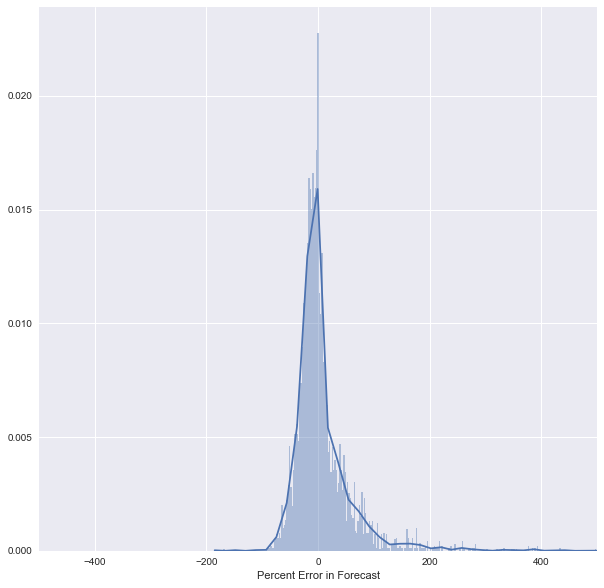

In [45]:
ax=sns.distplot(flatdata_adjusted['PercentError'],bins=1000,kde=True,axlabel='Percent Error in Forecast')
ax.figure.set_size_inches(10,10)
ax.set_xlim(-500,500)
ax.figure.savefig('segmentlevelPE.png')

# Project Level Inaccuracy
Group by Internal Project ID and take summation of the Weighted Percent Error column and then take the Absolute Value. Taking the absolute value later because that way we can assess the actual accuracy of forecast for each project, since positive and negative values will interact.

Creating another column to see how taking the Absolute Weighted Percent Error will affect.

#### Since we have already weighted the percent error, taking the summation will give the average error for a particular project.

In [46]:
flatdata_adjusted=flatdata_adjusted.drop_duplicates()

In [38]:
flatdata_adjusted.to_csv('flatdata_adjusted_dupli.csv')

Adjust Improvement Types. Get rid of the Zeros and combinations. COmbinations are taken to be th improvement type with higher number (e.g. for 1,2, the improvement type is 2 etc.). 
Adjust the Functional Classes. Blanks and Zero values to be taken to be Unknown Functional Class (Type 6). 
Adjust the Forecast Method, Combinations are taken as Professional Judgement(type 5). Unknoiwns as Type 6.

In [3]:
flatdata_adjusted=pd.read_csv('flatdata_adjusted_dupli.csv')
flatdata_adjusted['ImprovementType'].describe()

count    5118.000000
mean        7.544158
std         5.221936
min         1.000000
25%         1.000000
50%        12.000000
75%        12.000000
max        12.000000
Name: ImprovementType, dtype: float64

In [4]:
flatdata_adjusted=flatdata_adjusted.assign(DiffYear=flatdata_adjusted['ForecastYear']-flatdata_adjusted['YearForecastProduced'])

In [5]:
flatdata_adjusted['FunctionalClass'].describe()

count    5118.000000
mean        5.123486
std         2.613384
min         1.000000
25%         3.000000
50%         4.000000
75%         8.000000
max         8.000000
Name: FunctionalClass, dtype: float64

In [6]:
flatdata_adjusted

,AdjustedForecast,BriefDescription,Count,County,ForecastMethodology,ForecastYear,ForecastYearType,FunctionalClass,ImprovementType,InternalProjectID,...,TollType,TrafficForecast,YearForecastProduced,Year_ofObservation,main_ProjectInformation_ProjectID,main_TrafficForecast_ProjectID,Error,PercentError,AbsPE,DiffYear
0,5300.0,NaN,3700,Washington,1,2010,1.0,3,12,1663,...,1,5300,2007.0,2010,58-6231-1663-,6231.0,-1600.0,-30.188679,30.188679,3.0
1,7400.0,NaN,5500,Washington,1,2010,1.0,3,12,1663,...,1,7400,2007.0,2010,58-6232-1663-,6232.0,-1900.0,-25.675676,25.675676,3.0
2,4150.0,NaN,2800,Washington,1,2010,1.0,3,12,1663,...,1,4150,2007.0,2010,58-6233-1663-,6233.0,-1350.0,-32.530120,32.530120,3.0
3,3700.0,NaN,2500,Washington,1,2010,1.0,3,12,1663,...,1,3700,2007.0,2010,58-6234-1663-,6234.0,-1200.0,-32.432432,32.432432,3.0
4,4500.0,NaN,3500,Washington,1,2010,1.0,3,12,1663,...,1,4500,2007.0,2010,58-6235-1663-,6235.0,-1000.0,-22.222222,22.222222,3.0
5,18800.0,NaN,14000,Washington,1,2007,1.0,4,12,2015,...,1,18800,2005.0,2007,58-6236-2015-,6236.0,-4800.0,-25.531915,25.531915,2.0
6,18200.0,NaN,14700,Washington,1,2007,1.0,4,12,2015,...,1,18200,2005.0,2007,58-6237-2015-,6237.0,-3500.0,-19.230769,19.230769,2.0
7,19600.0,NaN,16900,Washington,1,2007,1.0,4,12,2015,...,1,19600,2005.0,2007,58-6238-2015-,6238.0,-2700.0,-13.775510,13.775510,2.0
8,1300.0,NaN,1900,Washington,1,2007,1.0,8,12,2126,...,1,1300,2006.0,2007,58-6239-2126-,6239.0,600.0,46.153846,46.153846,1.0
9,1300.0,NaN,1000,Washington,1,2010,1.0,5,12,2486,...,1,1300,2007.0,2010,58-6240-2486-,6240.0,-300.0,-23.076923,23.076923,3.0


In [ ]:
sns.set(color_codes=True)

ax = sns.regplot(x="total_bill", y="tip", data=tips)

In [7]:
averagecount=flatdata_adjusted['Count'].groupby(flatdata_adjusted['InternalProjectID']).mean().to_frame(name='AverageCount')
averageforecast=flatdata_adjusted['AdjustedForecast'].groupby(flatdata_adjusted['InternalProjectID']).mean().to_frame(name='AverageForecast')
improvement_type=flatdata_adjusted['ImprovementType'].groupby(flatdata_adjusted['InternalProjectID']).mean().to_frame(name='ImprovementType')
forecast_method=flatdata_adjusted['ForecastMethodology'].groupby(flatdata_adjusted['InternalProjectID']).mean().to_frame(name='Forecast_Method')
func_class=flatdata_adjusted['FunctionalClass'].groupby(flatdata_adjusted['InternalProjectID']).mean().to_frame(name='Func_Class')
diff_year=flatdata_adjusted['DiffYear'].groupby(flatdata_adjusted['InternalProjectID']).mean().to_frame(name='Diff_Year')
#project_error=pd.merge(averagecount,averageforecast,left_on='InternalProjectID')
#project_error
#func_class

In [7]:
diff_year

,Diff_Year
InternalProjectID,
10914,1.000000
12343,5.000000
12356,3.000000
13364,1.000000
13486,5.000000
13624,0.000000
14821,2.000000
16144,6.000000
16514,6.000000


In [15]:
#flatdata_adjusted=flatdata_adjusted.assign(DiffYear=flatdata_adjusted['ForecastYear']-flatdata_adjusted['YearForecastProduced'])

In [8]:
pd.options.display.max_columns=50

In [7]:
flatdata_adjusted[flatdata_adjusted['DiffYear']<0].to_csv('negativeyears.csv')

In [9]:
flatdata_adjusted_year=flatdata_adjusted[flatdata_adjusted['DiffYear']>=0]
flatdata_adjusted_year

,AdjustedForecast,BriefDescription,Count,County,ForecastMethodology,ForecastYear,ForecastYearType,FunctionalClass,ImprovementType,InternalProjectID,Length_miles,SegmentDescription,SegmentID,State,TollType,TrafficForecast,YearForecastProduced,Year_ofObservation,main_ProjectInformation_ProjectID,main_TrafficForecast_ProjectID,Error,PercentError,AbsPE,DiffYear
0,5300.0,NaN,3700,Washington,1,2010,1.0,3,12,1663,NaN,NaN,NaN,58,1,5300,2007.0,2010,58-6231-1663-,6231.0,-1600.0,-30.188679,30.188679,3.0
1,7400.0,NaN,5500,Washington,1,2010,1.0,3,12,1663,NaN,NaN,NaN,58,1,7400,2007.0,2010,58-6232-1663-,6232.0,-1900.0,-25.675676,25.675676,3.0
2,4150.0,NaN,2800,Washington,1,2010,1.0,3,12,1663,NaN,NaN,NaN,58,1,4150,2007.0,2010,58-6233-1663-,6233.0,-1350.0,-32.530120,32.530120,3.0
3,3700.0,NaN,2500,Washington,1,2010,1.0,3,12,1663,NaN,NaN,NaN,58,1,3700,2007.0,2010,58-6234-1663-,6234.0,-1200.0,-32.432432,32.432432,3.0
4,4500.0,NaN,3500,Washington,1,2010,1.0,3,12,1663,NaN,NaN,NaN,58,1,4500,2007.0,2010,58-6235-1663-,6235.0,-1000.0,-22.222222,22.222222,3.0
5,18800.0,NaN,14000,Washington,1,2007,1.0,4,12,2015,NaN,NaN,NaN,58,1,18800,2005.0,2007,58-6236-2015-,6236.0,-4800.0,-25.531915,25.531915,2.0
6,18200.0,NaN,14700,Washington,1,2007,1.0,4,12,2015,NaN,NaN,NaN,58,1,18200,2005.0,2007,58-6237-2015-,6237.0,-3500.0,-19.230769,19.230769,2.0
7,19600.0,NaN,16900,Washington,1,2007,1.0,4,12,2015,NaN,NaN,NaN,58,1,19600,2005.0,2007,58-6238-2015-,6238.0,-2700.0,-13.775510,13.775510,2.0
8,1300.0,NaN,1900,Washington,1,2007,1.0,8,12,2126,NaN,NaN,NaN,58,1,1300,2006.0,2007,58-6239-2126-,6239.0,600.0,46.153846,46.153846,1.0
9,1300.0,NaN,1000,Washington,1,2010,1.0,5,12,2486,NaN,NaN,NaN,58,1,1300,2007.0,2010,58-6240-2486-,6240.0,-300.0,-23.076923,23.076923,3.0


(-50, 200)

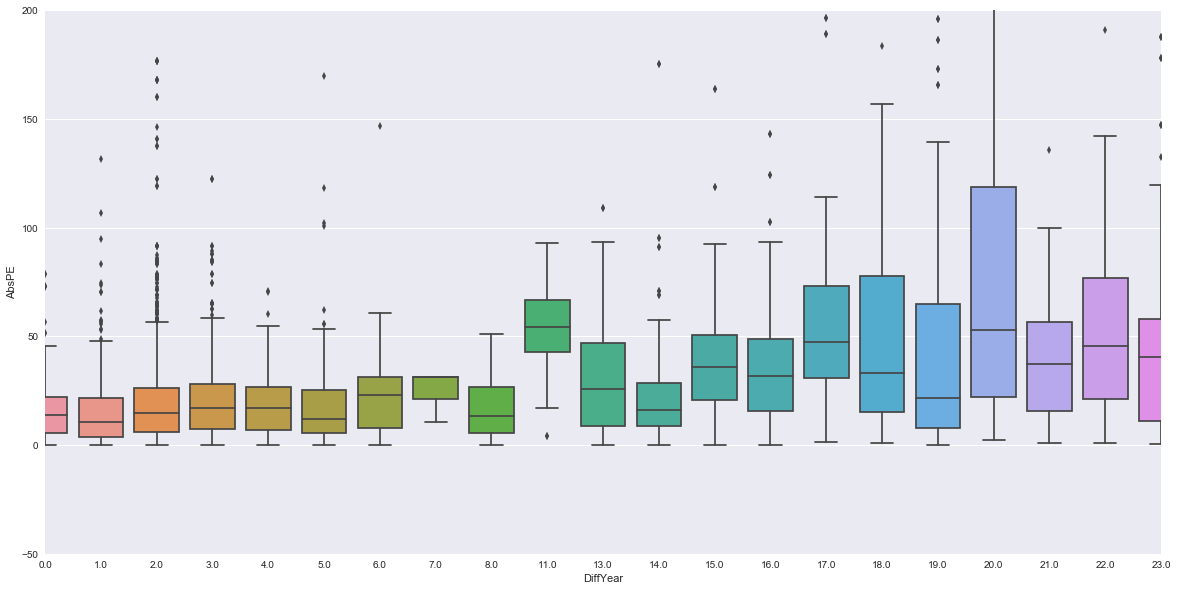

In [10]:
ax=sns.boxplot(flatdata_adjusted_year['DiffYear'],flatdata_adjusted_year['AbsPE'])
ax.figure.set_size_inches(20,10)
ax.set_xlim(0
            ,20)
ax.set_ylim(-50,200)
#ax.figure.savefig('boxplotyear.png')

(-50, 200)

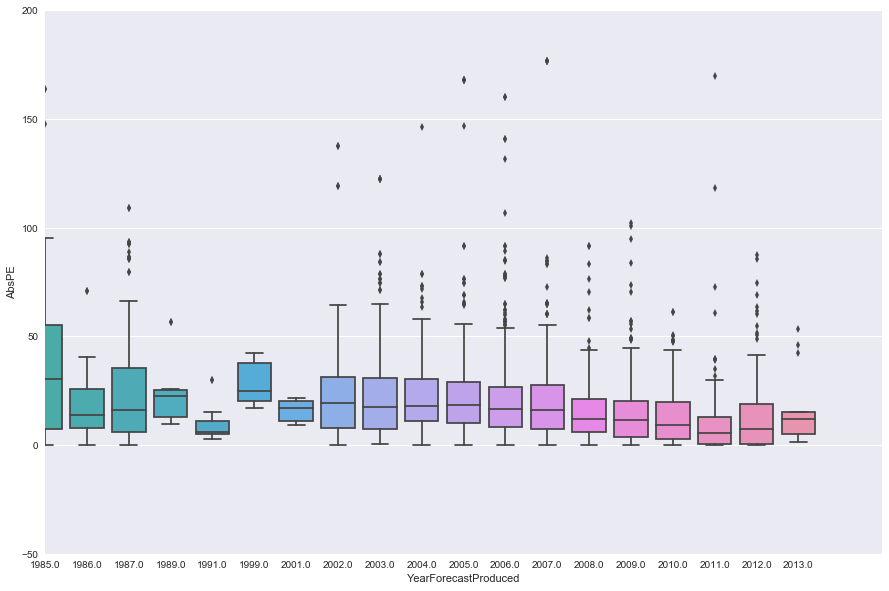

In [12]:
ax=sns.boxplot(flatdata_adjusted_year['YearForecastProduced'],flatdata_adjusted_year['AbsPE'])
ax.figure.set_size_inches(15,10)
ax.set_xlim(20,40)
ax.set_ylim(-50,200)
#ax.figure.savefig('boxplotyearforecastproduced.png')

In [31]:
flatdata_adjusted_year[flatdata_adjusted_year['DiffYear']==18]['AbsPE'].describe().to_csv('diffyear.csv')

In [34]:
flatdata_adjusted_year[flatdata_adjusted_year['DiffYear']==23]

,AdjustedForecast,BriefDescription,Count,County,ForecastMethodology,ForecastYear,ForecastYearType,FunctionalClass,ImprovementType,InternalProjectID,Length_miles,SegmentDescription,SegmentID,State,TollType,TrafficForecast,YearForecastProduced,Year_ofObservation,main_ProjectInformation_ProjectID,main_TrafficForecast_ProjectID,Error,PercentError,AbsPE,DiffYear
796,3500.0,TH 13 - TH 35E Interchange Area,3450,NaN,1,2003,1.0,8,12,TA-M245,0.10,", , , TH 13West of Victoria StEB",NaN,28,1,3500,1980.0,2003,28-7051-TA-M245-TH 13 - TH 35E Interchange Area,7051.0,-50.0,-1.428571,1.428571,23.0
797,3500.0,TH 13 - TH 35E Interchange Area,3450,NaN,1,2003,1.0,8,12,TA-M245,0.10,", , , WB",NaN,28,1,3500,1980.0,2003,28-7052-TA-M245-TH 13 - TH 35E Interchange Area,7052.0,-50.0,-1.428571,1.428571,23.0
798,3000.0,TH 13 - TH 35E Interchange Area,3450,NaN,1,2003,1.0,8,12,TA-M245,NaN,", , , TH 13Between Victoria RdEB",NaN,28,1,3000,1980.0,2003,28-7053-TA-M245-TH 13 - TH 35E Interchange Area,7053.0,450.0,15.000000,15.000000,23.0
799,3000.0,TH 13 - TH 35E Interchange Area,3450,NaN,1,2003,1.0,8,12,TA-M245,NaN,", , , WB",NaN,28,1,3000,1980.0,2003,28-7054-TA-M245-TH 13 - TH 35E Interchange Area,7054.0,450.0,15.000000,15.000000,23.0
800,4500.0,TH 13 - TH 35E Interchange Area,3450,NaN,1,2003,1.0,8,12,TA-M245,0.12,", , , TH 13Victoria StTH 35EEB",NaN,28,1,4500,1980.0,2003,28-7055-TA-M245-TH 13 - TH 35E Interchange Area,7055.0,-1050.0,-23.333333,23.333333,23.0
801,4500.0,TH 13 - TH 35E Interchange Area,3450,NaN,1,2003,1.0,8,12,TA-M245,0.12,", , , WB",NaN,28,1,4500,1980.0,2003,28-7056-TA-M245-TH 13 - TH 35E Interchange Area,7056.0,-1050.0,-23.333333,23.333333,23.0
802,1200.0,TH 13 - TH 35E Interchange Area,3450,NaN,1,2003,1.0,8,12,TA-M245,NaN,", , , TH 13Between TH 35E RampsEB",NaN,28,1,1200,1980.0,2003,28-7057-TA-M245-TH 13 - TH 35E Interchange Area,7057.0,2250.0,187.500000,187.500000,23.0
803,1200.0,TH 13 - TH 35E Interchange Area,3450,NaN,1,2003,1.0,8,12,TA-M245,NaN,", , , WB",NaN,28,1,1200,1980.0,2003,28-7058-TA-M245-TH 13 - TH 35E Interchange Area,7058.0,2250.0,187.500000,187.500000,23.0
804,8200.0,TH 13 - TH 35E Interchange Area,3450,NaN,1,2003,1.0,8,12,TA-M245,0.13,", , , TH 13TH 35ECR 45EB",NaN,28,1,8200,1980.0,2003,28-7059-TA-M245-TH 13 - TH 35E Interchange Area,7059.0,-4750.0,-57.926829,57.926829,23.0
805,8200.0,TH 13 - TH 35E Interchange Area,3450,NaN,1,2003,1.0,8,12,TA-M245,0.13,", , , WB",NaN,28,1,8200,1980.0,2003,28-7060-TA-M245-TH 13 - TH 35E Interchange Area,7060.0,-4750.0,-57.926829,57.926829,23.0


In [35]:
project_error=pd.merge(averagecount,averageforecast,left_index=True,right_index=True)
project_error

,AverageCount,AverageForecast
InternalProjectID,,
10914,67797.500000,69861.250000
12343,99720.000000,99724.000000
12356,28800.000000,31001.000000
13364,4610.000000,4910.000000
13486,53705.000000,60317.500000
13624,580.000000,635.000000
14821,34445.000000,28621.750000
16144,15556.000000,16568.736842
16514,54630.000000,58143.333333


In [12]:
#pd.cut(flatdata_adjusted['TrafficForecast'],bins=10)

In [13]:
import numpy as np
import pandas

#df = pd.DataFrame({"a": np.random.random(100), 
#                       "b": np.random.random(100) + 10})

# Bin the data frame by "a" with 10 bins...
#bins = np.linspace(flatdata_adjusted['TrafficForecast'].min(), flatdata_adjusted['TrafficForecast'].max(), 10)
bins=15
grouped = flatdata_adjusted.groupby(pd.qcut(flatdata_adjusted['TrafficForecast'], bins))

# Get the mean of b, binned by the values in a
grouped.mean().AbsPE

TrafficForecast
(169.999, 2850.0]      59.577410
(2850.0, 4800.0]       72.434665
(4800.0, 6900.0]       45.253134
(6900.0, 9000.0]       37.466641
(9000.0, 11370.0]      28.359897
(11370.0, 13800.0]     36.889722
(13800.0, 16600.0]     42.326692
(16600.0, 19600.0]     28.026348
(19600.0, 22466.0]     33.636729
(22466.0, 26400.0]     35.046233
(26400.0, 31500.0]     32.477143
(31500.0, 38000.0]     29.840369
(38000.0, 46750.0]     27.156921
(46750.0, 59250.0]     21.666160
(59250.0, 179400.0]    14.303857
Name: AbsPE, dtype: float64

In [21]:
flatdata_grouped=flatdata_adjusted.groupby(pd.qcut(flatdata_adjusted['TrafficForecast'], 15)).AbsPE.describe()
#grouped statistics of the Absolute Percent Error

In [24]:
flatdata_grouped=flatdata_grouped.assign(LowerLimit=flatdata_grouped['mean']-1.645*flatdata_grouped['std']/np.sqrt(flatdata_grouped['count']))
flatdata_grouped

,count,mean,std,min,25%,50%,75%,max,LowerLimit
TrafficForecast,,,,,,,,,
"(169.999, 2850.0]",343.0,59.577410,184.532592,0.000000,7.217021,16.279070,39.189257,1755.072464,43.186920
"(2850.0, 4800.0]",345.0,72.434665,185.619751,0.000000,8.082409,22.500000,56.403270,2142.424242,55.995470
"(4800.0, 6900.0]",339.0,45.253134,117.981410,0.000000,10.745415,20.204153,39.410700,1186.956522,34.712187
"(6900.0, 9000.0]",344.0,37.466641,108.330773,0.000000,7.988636,18.087847,35.714286,1328.571429,27.858519
"(9000.0, 11370.0]",336.0,28.359897,62.646904,0.000000,8.664117,20.088056,37.300532,1096.781076,22.737832
"(11370.0, 13800.0]",341.0,36.889722,57.763643,0.000000,7.546553,19.047619,40.615616,392.424242,31.744036
"(13800.0, 16600.0]",344.0,42.326692,66.185035,0.000000,9.272849,22.455471,42.405063,434.296029,36.456579
"(16600.0, 19600.0]",347.0,28.026348,34.365323,0.000000,7.736073,16.071429,36.442975,328.985507,24.991607
"(19600.0, 22466.0]",332.0,33.636729,43.518645,0.000000,8.724220,18.332728,40.353207,262.500000,29.707817


In [33]:
flatdata_2=pd.merge(flatdata_adjusted,flatdata_grouped,how='left')
flatdata_2

MergeError: No common columns to perform merge on

In [25]:
flatdata_grouped=flatdata_grouped.assign(UpperLimit=flatdata_grouped['mean']+1.645*flatdata_grouped['std']/np.sqrt(flatdata_grouped['count']))
flatdata_grouped

,count,mean,std,min,25%,50%,75%,max,LowerLimit,UpperLimit
TrafficForecast,,,,,,,,,,
"(169.999, 2850.0]",343.0,59.577410,184.532592,0.000000,7.217021,16.279070,39.189257,1755.072464,43.186920,75.967899
"(2850.0, 4800.0]",345.0,72.434665,185.619751,0.000000,8.082409,22.500000,56.403270,2142.424242,55.995470,88.873860
"(4800.0, 6900.0]",339.0,45.253134,117.981410,0.000000,10.745415,20.204153,39.410700,1186.956522,34.712187,55.794081
"(6900.0, 9000.0]",344.0,37.466641,108.330773,0.000000,7.988636,18.087847,35.714286,1328.571429,27.858519,47.074763
"(9000.0, 11370.0]",336.0,28.359897,62.646904,0.000000,8.664117,20.088056,37.300532,1096.781076,22.737832,33.981962
"(11370.0, 13800.0]",341.0,36.889722,57.763643,0.000000,7.546553,19.047619,40.615616,392.424242,31.744036,42.035408
"(13800.0, 16600.0]",344.0,42.326692,66.185035,0.000000,9.272849,22.455471,42.405063,434.296029,36.456579,48.196806
"(16600.0, 19600.0]",347.0,28.026348,34.365323,0.000000,7.736073,16.071429,36.442975,328.985507,24.991607,31.061089
"(19600.0, 22466.0]",332.0,33.636729,43.518645,0.000000,8.724220,18.332728,40.353207,262.500000,29.707817,37.565640


In [27]:
flatdata_adjusted

,AdjustedForecast,BriefDescription,Count,County,ForecastMethodology,ForecastYear,ForecastYearType,FunctionalClass,ImprovementType,InternalProjectID,Length_miles,SegmentDescription,SegmentID,State,TollType,TrafficForecast,YearForecastProduced,Year_ofObservation,main_ProjectInformation_ProjectID,main_TrafficForecast_ProjectID,Error,PercentError,AbsPE,DiffYear
0,5300.0,NaN,3700,Washington,1,2010,1.0,3,12,1663,NaN,NaN,NaN,58,1,5300,2007.0,2010,58-6231-1663-,6231.0,-1600.0,-30.188679,30.188679,3.0
1,7400.0,NaN,5500,Washington,1,2010,1.0,3,12,1663,NaN,NaN,NaN,58,1,7400,2007.0,2010,58-6232-1663-,6232.0,-1900.0,-25.675676,25.675676,3.0
2,4150.0,NaN,2800,Washington,1,2010,1.0,3,12,1663,NaN,NaN,NaN,58,1,4150,2007.0,2010,58-6233-1663-,6233.0,-1350.0,-32.530120,32.530120,3.0
3,3700.0,NaN,2500,Washington,1,2010,1.0,3,12,1663,NaN,NaN,NaN,58,1,3700,2007.0,2010,58-6234-1663-,6234.0,-1200.0,-32.432432,32.432432,3.0
4,4500.0,NaN,3500,Washington,1,2010,1.0,3,12,1663,NaN,NaN,NaN,58,1,4500,2007.0,2010,58-6235-1663-,6235.0,-1000.0,-22.222222,22.222222,3.0
5,18800.0,NaN,14000,Washington,1,2007,1.0,4,12,2015,NaN,NaN,NaN,58,1,18800,2005.0,2007,58-6236-2015-,6236.0,-4800.0,-25.531915,25.531915,2.0
6,18200.0,NaN,14700,Washington,1,2007,1.0,4,12,2015,NaN,NaN,NaN,58,1,18200,2005.0,2007,58-6237-2015-,6237.0,-3500.0,-19.230769,19.230769,2.0
7,19600.0,NaN,16900,Washington,1,2007,1.0,4,12,2015,NaN,NaN,NaN,58,1,19600,2005.0,2007,58-6238-2015-,6238.0,-2700.0,-13.775510,13.775510,2.0
8,1300.0,NaN,1900,Washington,1,2007,1.0,8,12,2126,NaN,NaN,NaN,58,1,1300,2006.0,2007,58-6239-2126-,6239.0,600.0,46.153846,46.153846,1.0
9,1300.0,NaN,1000,Washington,1,2010,1.0,5,12,2486,NaN,NaN,NaN,58,1,1300,2007.0,2010,58-6240-2486-,6240.0,-300.0,-23.076923,23.076923,3.0


(0, 500)

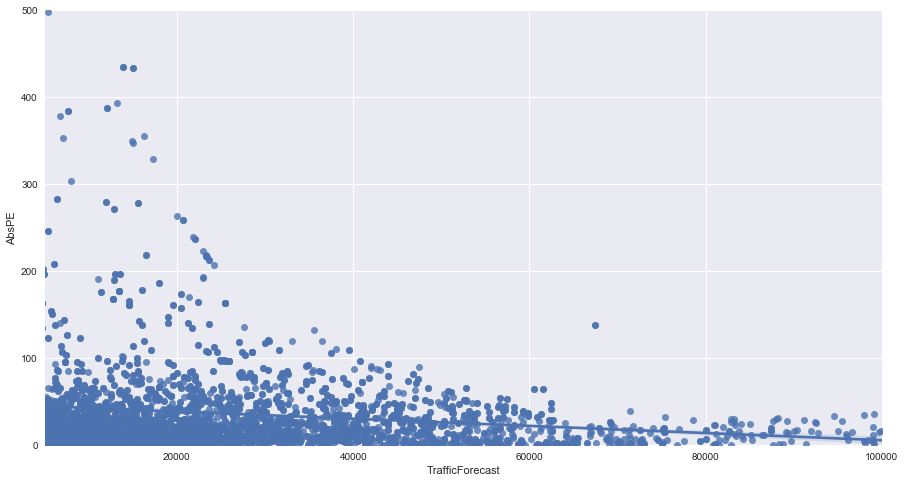

In [31]:
ax=sns.regplot(flatdata_adjusted['TrafficForecast'],flatdata_adjusted['AbsPE'])
ax.figure.set_size_inches(15,8)
ax.set_xlim(5000,100000)
ax.set_ylim(0,500)

In [16]:
flatdata_adjusted[flatdata_adjusted['TrafficForecast']<4801.0].describe()

,AdjustedForecast,Count,ForecastMethodology,ForecastYear,ForecastYearType,FunctionalClass,ImprovementType,Length_miles,SegmentID,State,TollType,TrafficForecast,YearForecastProduced,Year_ofObservation,main_TrafficForecast_ProjectID,Error,PercentError,AbsPE,DiffYear
count,688.000000,688.000000,688.000000,688.000000,403.0,688.000000,688.000000,149.000000,44.000000,688.000000,688.0,688.000000,688.000000,688.000000,403.000000,688.000000,688.000000,688.000000,688.000000
mean,2817.110972,4144.658430,3.505814,2005.690407,1.0,5.526163,7.286337,2.355208,1.272727,40.036337,1.0,2816.161337,1996.113372,2005.590116,7337.119107,1327.547459,45.448074,66.024725,9.577035
std,1206.793081,5591.419763,2.331350,7.923309,0.0,1.803090,5.377807,4.911036,0.450511,13.114438,0.0,1203.403032,77.621062,7.715880,998.496133,5346.510232,191.161381,185.055662,76.442003
min,170.000000,130.000000,1.000000,1980.000000,1.0,1.000000,1.000000,0.034000,1.000000,12.000000,1.0,170.000000,0.000000,1980.000000,6233.000000,-3207.000000,-85.862069,0.000000,0.000000
25%,1846.500000,1687.500000,1.000000,2004.750000,1.0,4.000000,1.000000,0.120000,1.000000,28.000000,1.0,1885.000000,1985.000000,2005.000000,6504.500000,-393.958333,-17.064154,7.421256,2.000000
50%,2900.000000,2860.000000,4.000000,2008.000000,1.0,5.000000,12.000000,0.250000,1.000000,41.000000,1.0,2880.000000,2006.000000,2009.000000,7023.000000,-29.166667,-1.505018,18.783034,2.000000
75%,3800.000000,4272.500000,6.000000,2010.000000,1.0,8.000000,12.000000,1.200000,2.000000,58.000000,1.0,3827.500000,2009.000000,2010.000000,8039.500000,681.250000,26.687205,46.121795,14.000000
max,4821.000000,74000.000000,6.000000,2016.000000,1.0,8.000000,12.000000,19.165001,2.000000,58.000000,1.0,4800.000000,2013.000000,2015.000000,9658.000000,70700.000000,2142.424242,2142.424242,2000.000000


In [49]:
flatdata_adjusted

,AdjustedForecast,BriefDescription,Count,County,ForecastMethodology,ForecastYear,ForecastYearType,FunctionalClass,ImprovementType,InternalProjectID,Length_miles,SegmentDescription,SegmentID,State,TollType,TrafficForecast,YearForecastProduced,Year_ofObservation,main_ProjectInformation_ProjectID,main_TrafficForecast_ProjectID,Error,PercentError,AbsPE,DiffYear
0,5300.0,NaN,3700,Washington,1,2010,1.0,3,12,1663,NaN,NaN,NaN,58,1,5300,2007.0,2010,58-6231-1663-,6231.0,-1600.0,-30.188679,30.188679,3.0
1,7400.0,NaN,5500,Washington,1,2010,1.0,3,12,1663,NaN,NaN,NaN,58,1,7400,2007.0,2010,58-6232-1663-,6232.0,-1900.0,-25.675676,25.675676,3.0
2,4150.0,NaN,2800,Washington,1,2010,1.0,3,12,1663,NaN,NaN,NaN,58,1,4150,2007.0,2010,58-6233-1663-,6233.0,-1350.0,-32.530120,32.530120,3.0
3,3700.0,NaN,2500,Washington,1,2010,1.0,3,12,1663,NaN,NaN,NaN,58,1,3700,2007.0,2010,58-6234-1663-,6234.0,-1200.0,-32.432432,32.432432,3.0
4,4500.0,NaN,3500,Washington,1,2010,1.0,3,12,1663,NaN,NaN,NaN,58,1,4500,2007.0,2010,58-6235-1663-,6235.0,-1000.0,-22.222222,22.222222,3.0
5,18800.0,NaN,14000,Washington,1,2007,1.0,4,12,2015,NaN,NaN,NaN,58,1,18800,2005.0,2007,58-6236-2015-,6236.0,-4800.0,-25.531915,25.531915,2.0
6,18200.0,NaN,14700,Washington,1,2007,1.0,4,12,2015,NaN,NaN,NaN,58,1,18200,2005.0,2007,58-6237-2015-,6237.0,-3500.0,-19.230769,19.230769,2.0
7,19600.0,NaN,16900,Washington,1,2007,1.0,4,12,2015,NaN,NaN,NaN,58,1,19600,2005.0,2007,58-6238-2015-,6238.0,-2700.0,-13.775510,13.775510,2.0
8,1300.0,NaN,1900,Washington,1,2007,1.0,8,12,2126,NaN,NaN,NaN,58,1,1300,2006.0,2007,58-6239-2126-,6239.0,600.0,46.153846,46.153846,1.0
9,1300.0,NaN,1000,Washington,1,2010,1.0,5,12,2486,NaN,NaN,NaN,58,1,1300,2007.0,2010,58-6240-2486-,6240.0,-300.0,-23.076923,23.076923,3.0


In [38]:
project_error=project_error.assign(Error=project_error['AverageCount']-project_error['AverageForecast'])

In [39]:
project_error

,AverageCount,AverageForecast,Error
InternalProjectID,,,
10914,67797.500000,69861.250000,-2063.750000
12343,99720.000000,99724.000000,-4.000000
12356,28800.000000,31001.000000,-2201.000000
13364,4610.000000,4910.000000,-300.000000
13486,53705.000000,60317.500000,-6612.500000
13624,580.000000,635.000000,-55.000000
14821,34445.000000,28621.750000,5823.250000
16144,15556.000000,16568.736842,-1012.736842
16514,54630.000000,58143.333333,-3513.333333


In [40]:
project_error=project_error.assign(PercentError=100*project_error['Error']/project_error['AverageForecast'])

In [41]:
project_error

,AverageCount,AverageForecast,Error,PercentError
InternalProjectID,,,,
10914,67797.500000,69861.250000,-2063.750000,-2.954070
12343,99720.000000,99724.000000,-4.000000,-0.004011
12356,28800.000000,31001.000000,-2201.000000,-7.099771
13364,4610.000000,4910.000000,-300.000000,-6.109980
13486,53705.000000,60317.500000,-6612.500000,-10.962822
13624,580.000000,635.000000,-55.000000,-8.661417
14821,34445.000000,28621.750000,5823.250000,20.345541
16144,15556.000000,16568.736842,-1012.736842,-6.112336
16514,54630.000000,58143.333333,-3513.333333,-6.042539


In [42]:
project_error=project_error.assign(AbsPE=np.abs(project_error['PercentError']))
project_error

,AverageCount,AverageForecast,Error,PercentError,AbsPE
InternalProjectID,,,,,
10914,67797.500000,69861.250000,-2063.750000,-2.954070,2.954070
12343,99720.000000,99724.000000,-4.000000,-0.004011,0.004011
12356,28800.000000,31001.000000,-2201.000000,-7.099771,7.099771
13364,4610.000000,4910.000000,-300.000000,-6.109980,6.109980
13486,53705.000000,60317.500000,-6612.500000,-10.962822,10.962822
13624,580.000000,635.000000,-55.000000,-8.661417,8.661417
14821,34445.000000,28621.750000,5823.250000,20.345541,20.345541
16144,15556.000000,16568.736842,-1012.736842,-6.112336,6.112336
16514,54630.000000,58143.333333,-3513.333333,-6.042539,6.042539


In [43]:
project_error=pd.merge(project_error,improvement_type,left_index=True,right_index=True)


In [44]:
project_error=pd.merge(project_error,func_class,left_index=True,right_index=True)

In [45]:
project_error=pd.merge(project_error,forecast_method,left_index=True,right_index=True)

In [46]:
project_error=pd.merge(project_error,diff_year,left_index=True,right_index=True)

In [47]:
project_error3=project_error.assign(AbsError=np.abs(project_error['Error']))
project_error3

,AverageCount,AverageForecast,Error,PercentError,AbsPE,ImprovementType,Func_Class,Forecast_Method,Diff_Year,AbsError
InternalProjectID,,,,,,,,,,
10914,67797.500000,69861.250000,-2063.750000,-2.954070,2.954070,11.000000,1.000000,6.0,1.000000,2063.750000
12343,99720.000000,99724.000000,-4.000000,-0.004011,0.004011,1.000000,1.000000,6.0,5.000000,4.000000
12356,28800.000000,31001.000000,-2201.000000,-7.099771,7.099771,12.000000,1.000000,6.0,3.000000,2201.000000
13364,4610.000000,4910.000000,-300.000000,-6.109980,6.109980,1.000000,5.000000,6.0,1.000000,300.000000
13486,53705.000000,60317.500000,-6612.500000,-10.962822,10.962822,3.000000,1.000000,6.0,5.000000,6612.500000
13624,580.000000,635.000000,-55.000000,-8.661417,8.661417,1.000000,6.000000,6.0,0.000000,55.000000
14821,34445.000000,28621.750000,5823.250000,20.345541,20.345541,3.000000,4.000000,6.0,2.000000,5823.250000
16144,15556.000000,16568.736842,-1012.736842,-6.112336,6.112336,2.000000,3.000000,6.0,6.000000,1012.736842
16514,54630.000000,58143.333333,-3513.333333,-6.042539,6.042539,11.000000,1.000000,6.0,6.000000,3513.333333


In [48]:
project_error3.describe()

,AverageCount,AverageForecast,Error,PercentError,AbsPE,ImprovementType,Func_Class,Forecast_Method,Diff_Year,AbsError
count,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000
mean,22010.324168,23680.926968,-1670.602799,-4.269553,19.998517,4.857760,3.637880,4.461673,5.852678,3985.366491
std,24651.238662,26363.049489,8610.907902,47.785259,43.604446,5.002616,1.896852,2.052939,107.749257,7812.986273
min,130.000000,170.000000,-75773.666667,-86.645461,0.000000,1.000000,1.000000,1.000000,-1979.000000,0.000000
25%,6000.000000,6586.250000,-3050.825758,-19.039587,5.551854,1.000000,3.000000,4.000000,1.942308,498.000000
50%,13475.000000,14652.500000,-800.000000,-8.023657,12.702086,1.000000,3.000000,6.000000,2.000000,1700.000000
75%,29010.000000,30236.250000,87.000000,1.259960,23.526408,12.000000,4.333333,6.000000,4.000000,4565.859375
max,172000.000000,171196.666700,122766.666667,1096.781076,1096.781076,12.000000,8.000000,6.000000,2000.000000,122766.666667


## Unifying Improvement Type
Types 1 to 6 are resurfacing or improving on existing facility. To be rebranded as UnifiedType 1.
Types 7 to 11 are new facility. To be rebranded as UnifiedType 2.
Type 12 is unknown. To be rebranded as UnifiedType 3.

In [49]:
def UnifiedImprovement(x): #to adjust the forecast
    if x.ImprovementType<7:
        unifiedtype=1
    elif x.ImprovementType<12:
        unifiedtype=2
    else:
        unifiedtype=3
    return unifiedtype

In [50]:
project_error2=project_error.assign(UnifiedImprovementType=project_error.apply(UnifiedImprovement, axis=1))

In [51]:
project_error2

,AverageCount,AverageForecast,Error,PercentError,AbsPE,ImprovementType,Func_Class,Forecast_Method,Diff_Year,UnifiedImprovementType
InternalProjectID,,,,,,,,,,
10914,67797.500000,69861.250000,-2063.750000,-2.954070,2.954070,11.000000,1.000000,6.0,1.000000,2
12343,99720.000000,99724.000000,-4.000000,-0.004011,0.004011,1.000000,1.000000,6.0,5.000000,1
12356,28800.000000,31001.000000,-2201.000000,-7.099771,7.099771,12.000000,1.000000,6.0,3.000000,3
13364,4610.000000,4910.000000,-300.000000,-6.109980,6.109980,1.000000,5.000000,6.0,1.000000,1
13486,53705.000000,60317.500000,-6612.500000,-10.962822,10.962822,3.000000,1.000000,6.0,5.000000,1
13624,580.000000,635.000000,-55.000000,-8.661417,8.661417,1.000000,6.000000,6.0,0.000000,1
14821,34445.000000,28621.750000,5823.250000,20.345541,20.345541,3.000000,4.000000,6.0,2.000000,1
16144,15556.000000,16568.736842,-1012.736842,-6.112336,6.112336,2.000000,3.000000,6.0,6.000000,1
16514,54630.000000,58143.333333,-3513.333333,-6.042539,6.042539,11.000000,1.000000,6.0,6.000000,2


### Project level Analysis Results

In [64]:
project_error2.describe()

,AverageCount,AverageForecast,Error,PercentError,AbsPE,ImprovementType,Func_Class,Forecast_Method,UnifiedImprovementType
count,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000
mean,22010.324168,23680.926968,-1670.602799,-4.269553,19.998517,4.851339,3.608648,4.461673,1.634241
std,24651.238662,26363.049489,8610.907902,47.785259,43.604446,5.003328,1.897010,2.052939,0.916406
min,130.000000,170.000000,-75773.666667,-86.645461,0.000000,1.000000,0.384615,1.000000,1.000000
25%,6000.000000,6586.250000,-3050.825758,-19.039587,5.551854,1.000000,3.000000,4.000000,1.000000
50%,13475.000000,14652.500000,-800.000000,-8.023657,12.702086,1.000000,3.000000,6.000000,1.000000
75%,29010.000000,30236.250000,87.000000,1.259960,23.526408,12.000000,4.200000,6.000000,3.000000
max,172000.000000,171196.666700,122766.666667,1096.781076,1096.781076,12.000000,8.000000,6.000000,3.000000


In [54]:
#project_error2.describe() #the absolute weighted error was taken and then summed, which creates the average

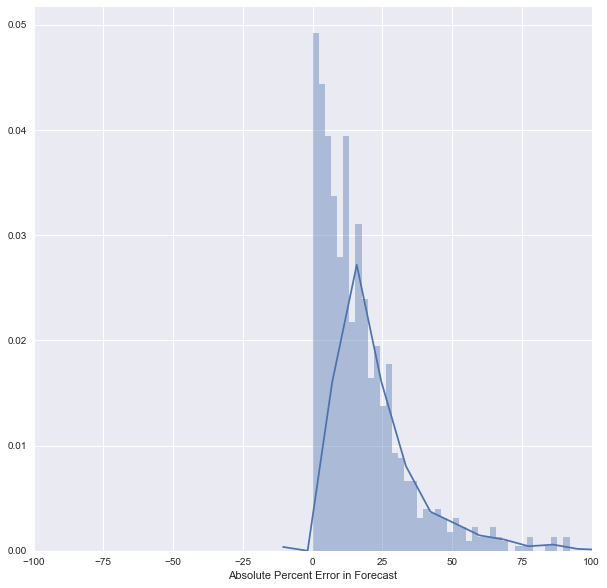

In [65]:
ax=sns.distplot(project_error2['AbsPE'],bins=500,kde=True,axlabel='Absolute Percent Error in Forecast')
ax.figure.set_size_inches(10,10)
ax.set_xlim(-100,100)
ax.figure.savefig('ProjectLevel PE.png')

In [6]:
new=flatdata_adjusted[flatdata_adjusted['ForecastYear']!=0]
new

,AdjustedForecast,BriefDescription,Count,County,ForecastMethodology,ForecastYear,ForecastYearType,FunctionalClass,ImprovementType,InternalProjectID,...,TollType,TrafficForecast,YearForecastProduced,Year_ofObservation,main_ProjectInformation_ProjectID,main_TrafficForecast_ProjectID,Error,PercentError,AbsPE,DiffYear
0,5300.0,NaN,3700,Washington,1,2010,1.0,3,12,1663,...,1,5300,2007.0,2010,58-6231-1663-,6231.0,-1600.0,-30.188679,30.188679,3.0
1,7400.0,NaN,5500,Washington,1,2010,1.0,3,12,1663,...,1,7400,2007.0,2010,58-6232-1663-,6232.0,-1900.0,-25.675676,25.675676,3.0
2,4150.0,NaN,2800,Washington,1,2010,1.0,3,12,1663,...,1,4150,2007.0,2010,58-6233-1663-,6233.0,-1350.0,-32.530120,32.530120,3.0
3,3700.0,NaN,2500,Washington,1,2010,1.0,3,12,1663,...,1,3700,2007.0,2010,58-6234-1663-,6234.0,-1200.0,-32.432432,32.432432,3.0
4,4500.0,NaN,3500,Washington,1,2010,1.0,3,12,1663,...,1,4500,2007.0,2010,58-6235-1663-,6235.0,-1000.0,-22.222222,22.222222,3.0
5,18800.0,NaN,14000,Washington,1,2007,1.0,4,12,2015,...,1,18800,2005.0,2007,58-6236-2015-,6236.0,-4800.0,-25.531915,25.531915,2.0
6,18200.0,NaN,14700,Washington,1,2007,1.0,4,12,2015,...,1,18200,2005.0,2007,58-6237-2015-,6237.0,-3500.0,-19.230769,19.230769,2.0
7,19600.0,NaN,16900,Washington,1,2007,1.0,4,12,2015,...,1,19600,2005.0,2007,58-6238-2015-,6238.0,-2700.0,-13.775510,13.775510,2.0
8,1300.0,NaN,1900,Washington,1,2007,1.0,8,12,2126,...,1,1300,2006.0,2007,58-6239-2126-,6239.0,600.0,46.153846,46.153846,1.0
9,1300.0,NaN,1000,Washington,1,2010,1.0,5,12,2486,...,1,1300,2007.0,2010,58-6240-2486-,6240.0,-300.0,-23.076923,23.076923,3.0


In [7]:
new['ForecastYear'].describe()

count    5090.000000
mean     2004.071709
std         8.400994
min      1975.000000
25%      2000.000000
50%      2007.000000
75%      2010.000000
max      2017.000000
Name: ForecastYear, dtype: float64

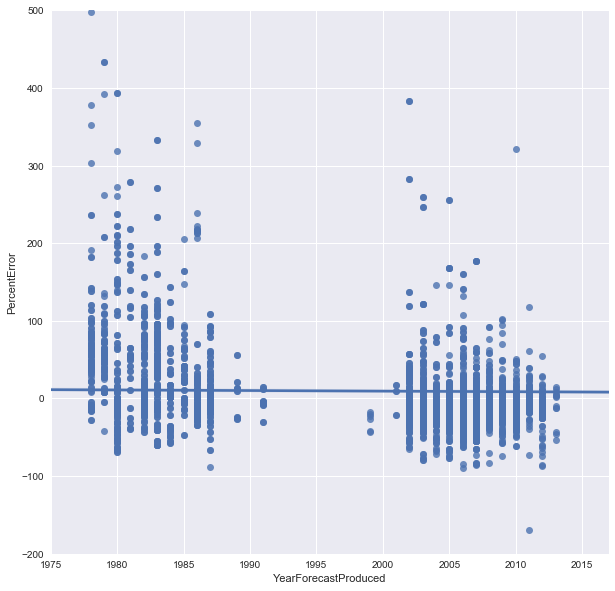

In [8]:
ax=sns.regplot(new['YearForecastProduced'],new['PercentError'])
ax.figure.set_size_inches(10,10)
ax.set_xlim(1975,2017)
ax.set_ylim(-200,500)
ax.figure.savefig('scatterplot4.png')

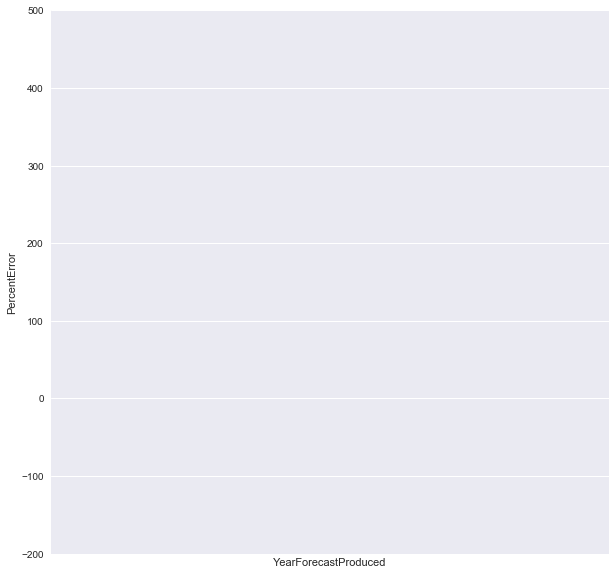

In [9]:
ax=sns.boxplot(new['YearForecastProduced'],new['PercentError'])
ax.figure.set_size_inches(10,10)
ax.set_xlim(1975,2017)
ax.set_ylim(-200,500)
ax.figure.savefig('scatterplot5.png')

In [70]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas.tseries 

In [71]:
newdf=new[['ForecastYear','PercentError']]
newdf

,ForecastYear,PercentError
0,2010,-30.188679
1,2010,-25.675676
2,2010,-32.530120
3,2010,-32.432432
4,2010,-22.222222
5,2007,-25.531915
6,2007,-19.230769
7,2007,-13.775510
8,2007,46.153846
9,2010,-23.076923


In [72]:
newdf=newdf.set_index('ForecastYear')
newdf

,PercentError
ForecastYear,
2010,-30.188679
2010,-25.675676
2010,-32.530120
2010,-32.432432
2010,-22.222222
2007,-25.531915
2007,-19.230769
2007,-13.775510
2007,46.153846


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000029DB8DAB128>],
      dtype=object)

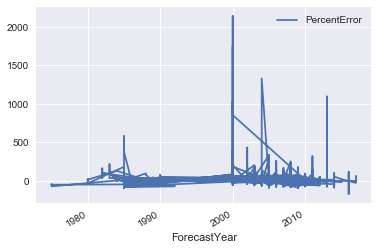

In [69]:
newdf.plot(subplots=True)

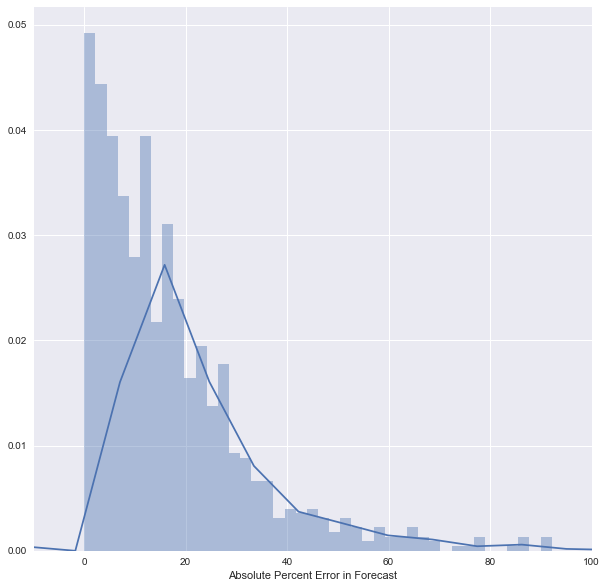

In [74]:
ax=sns.distplot(project_error2['AbsPE'],bins=500,kde=True,axlabel='Absolute Percent Error in Forecast')
ax.figure.set_size_inches(10,10)
ax.set_xlim(-10,100)
ax.figure.savefig('1.png')

In [75]:
error_imptype=project_error2['AbsPE'].groupby(project_error2['UnifiedImprovementType']).mean().to_frame(name='ByImprovementType')

In [76]:
project_error[project_error['ImprovementType']==3.076923]

,AverageCount,AverageForecast,Error,PercentError,AbsPE,ImprovementType,Func_Class,Forecast_Method
InternalProjectID,,,,,,,,


In [52]:
error_type1=project_error2[project_error2['UnifiedImprovementType']==1]

In [53]:
error_type1

,AverageCount,AverageForecast,Error,PercentError,AbsPE,ImprovementType,Func_Class,Forecast_Method,Diff_Year,UnifiedImprovementType
InternalProjectID,,,,,,,,,,
12343,99720.000000,99724.000000,-4.000000,-0.004011,0.004011,1.000000,1.000000,6.0,5.000000,1
13364,4610.000000,4910.000000,-300.000000,-6.109980,6.109980,1.000000,5.000000,6.0,1.000000,1
13486,53705.000000,60317.500000,-6612.500000,-10.962822,10.962822,3.000000,1.000000,6.0,5.000000,1
13624,580.000000,635.000000,-55.000000,-8.661417,8.661417,1.000000,6.000000,6.0,0.000000,1
14821,34445.000000,28621.750000,5823.250000,20.345541,20.345541,3.000000,4.000000,6.0,2.000000,1
16144,15556.000000,16568.736842,-1012.736842,-6.112336,6.112336,2.000000,3.000000,6.0,6.000000,1
16579,2190.000000,2193.500000,-3.500000,-0.159562,0.159562,1.000000,5.000000,6.0,0.000000,1
16592,2040.000000,2790.000000,-750.000000,-26.881720,26.881720,1.000000,5.000000,6.0,1.000000,1
16669,66695.000000,76644.500000,-9949.500000,-12.981362,12.981362,1.000000,1.000000,6.0,2.000000,1


In [54]:
error_method1=project_error2[project_error2['Forecast_Method']==1]#forecasts done by Traffic Count Trend
error_method2=project_error2[project_error2['Forecast_Method']==4]#forecasts done by TDM

In [61]:
error_method2[error_method2['ImprovementType']>1].describe()

,AverageCount,AverageForecast,Error,PercentError,AbsPE,ImprovementType,Func_Class,Forecast_Method,Diff_Year,UnifiedImprovementType
count,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.0,75.000000,75.000000
mean,13586.683264,15184.495389,-1597.812125,-10.252617,20.669058,9.733333,3.657439,4.0,2.333333,2.466667
std,12428.470193,13678.414651,3996.848490,25.687182,18.258830,3.810843,1.065679,0.0,1.703203,0.890389
min,260.000000,470.000000,-14300.000000,-85.862069,0.213675,2.000000,1.000000,4.0,0.000000,1.000000
25%,4700.000000,5450.000000,-2962.500000,-22.205349,8.703297,4.000000,3.000000,4.0,1.000000,1.000000
50%,9283.333333,9800.000000,-1000.000000,-12.977099,16.731518,12.000000,3.333333,4.0,2.000000,3.000000
75%,17433.333333,21450.000000,-99.166667,-1.616316,26.343391,12.000000,4.000000,4.0,3.000000,3.000000
max,56500.000000,51866.666667,12600.000000,90.740741,90.740741,12.000000,7.347826,4.0,8.000000,3.000000


In [62]:
error_method2[error_method2['ImprovementType']==1].describe()

,AverageCount,AverageForecast,Error,PercentError,AbsPE,ImprovementType,Func_Class,Forecast_Method,Diff_Year,UnifiedImprovementType
count,59.000000,59.000000,59.000000,59.000000,59.000000,59.0,59.000000,59.0,59.000000,59.0
mean,21101.254237,24230.282486,-3129.028249,-11.525415,20.474225,1.0,3.220339,4.0,2.610169,1.0
std,14227.519398,14514.948075,6506.793789,24.336185,17.348025,0.0,0.589207,0.0,0.965204,0.0
min,2050.000000,2300.000000,-22400.000000,-77.826444,0.427350,1.0,1.000000,4.0,0.000000,1.0
25%,11850.000000,13550.000000,-6020.000000,-26.682332,7.836211,1.0,3.000000,4.0,2.000000,1.0
50%,19800.000000,23400.000000,-2050.000000,-11.314985,14.130435,1.0,3.000000,4.0,3.000000,1.0
75%,29000.000000,33575.000000,475.000000,5.122439,28.125461,1.0,3.000000,4.0,3.000000,1.0
max,63291.000000,67900.000000,15981.000000,40.597540,77.826444,1.0,5.000000,4.0,7.000000,1.0


## error_method2
59 unique projects that have been forecasted using Travel Demand Model for low-risk projects (type 1, resurfacing/minor improvements).
75 unique projects that have been forecasted using Travel Demand Model for high-risk projects (type 2-12, major improvements)

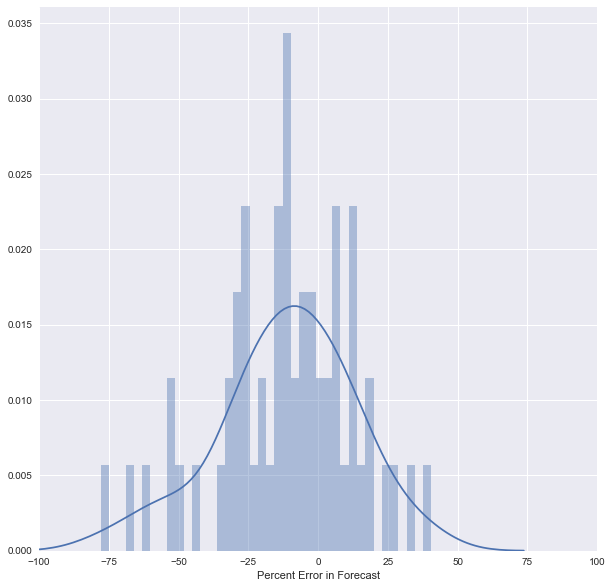

In [84]:
tdm_lowrisk=error_method2[error_method2['ImprovementType']==1]
ax=sns.distplot(tdm_lowrisk['PercentError'],bins=40,kde=True,axlabel='Percent Error in Forecast')
ax.figure.set_size_inches(10,10)
ax.set_xlim(-100,100)
ax.figure.savefig('tdm_lowrisk.png')

In [150]:
tct_lowrisk['AbsPE'].describe()

count    41.000000
mean     21.576844
std      19.044191
min       1.923077
25%       8.192090
50%      18.052257
75%      27.431421
max      91.780822
Name: AbsPE, dtype: float64

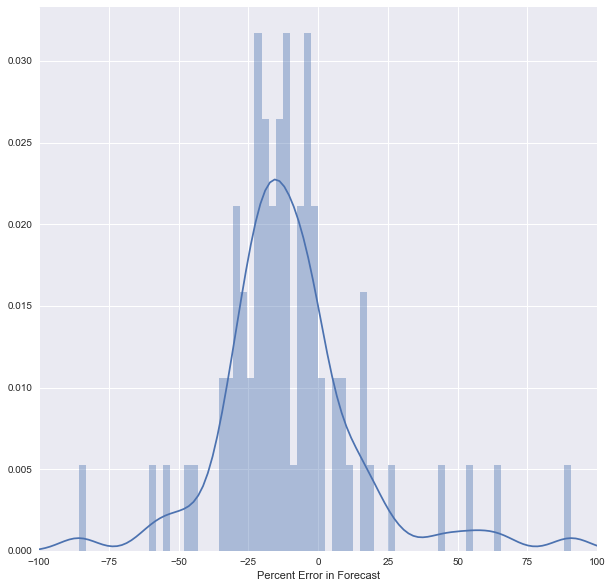

In [82]:
tdm_highrisk=error_method2[error_method2['ImprovementType']>1]
ax=sns.distplot(tdm_highrisk['PercentError'],bins=70,kde=True,axlabel='Percent Error in Forecast')
ax.figure.set_size_inches(10,10)
ax.set_xlim(-100,100)
ax.figure.savefig('tdm_highrisk.png')

In [88]:
tdm_lowrisk.groupby(tdm_lowrisk['Func_Class']).mean()

,AverageCount,AverageForecast,Error,PercentError,AbsPE,ImprovementType,Forecast_Method,Diff_Year,UnifiedImprovementType
Func_Class,,,,,,,,,
1.0,26283.000000,30600.000000,-4317.000000,-14.107843,14.107843,1.0,4.0,2.000000,1
3.0,22806.666667,26434.814815,-3628.148148,-11.686301,20.875800,1.0,4.0,2.666667,1
4.0,15690.090909,15265.454545,424.636364,-3.186853,13.591610,1.0,4.0,2.363636,1
5.0,9900.000000,20750.000000,-10850.000000,-52.476359,52.476359,1.0,4.0,3.000000,1


In [89]:
tdm_highrisk.groupby(tdm_highrisk['Func_Class']).mean()

,AverageCount,AverageForecast,Error,PercentError,AbsPE,ImprovementType,Forecast_Method,Diff_Year,UnifiedImprovementType
Func_Class,,,,,,,,,
1.000000,27883.333333,28605.555556,-722.222222,-9.372673,13.148293,8.666667,4.0,1.333333,2.333333
3.000000,19985.798851,22929.333333,-2943.534483,-9.646991,22.403759,7.655172,4.0,3.137931,1.965517
3.250000,8725.000000,11675.000000,-2950.000000,-25.267666,25.267666,12.000000,4.0,1.000000,3.000000
3.333333,16243.333333,17743.333333,-1500.000000,-10.324216,10.409686,12.000000,4.0,1.600000,3.000000
3.500000,13200.000000,14650.000000,-1450.000000,-9.897611,9.897611,12.000000,4.0,3.000000,3.000000
3.600000,6900.000000,7780.000000,-880.000000,-11.311054,11.311054,12.000000,4.0,1.000000,3.000000
3.666667,8683.333333,9575.000000,-891.666667,-8.715270,8.715270,12.000000,4.0,2.000000,3.000000
3.800000,5100.000000,5250.000000,-150.000000,-2.857143,2.857143,12.000000,4.0,1.000000,3.000000
3.833333,2383.333333,2481.666667,-98.333333,-3.962391,3.962391,12.000000,4.0,1.000000,3.000000


In [94]:
flatdata_adjusted['AbsPE'].groupby([flatdata_adjusted['ForecastMethodology'],flatdata_adjusted['FunctionalClass']]).describe().to_csv('ResultByMethod&FuncClass.csv')

In [95]:
flatdata_adjusted['AbsPE'].groupby([flatdata_adjusted['ForecastMethodology'],flatdata_adjusted['ImprovementType']]).describe().to_csv('ResultByMethod&ImprovementType.csv')

In [97]:
project_error2['AbsPE'].groupby([project_error2['Forecast_Method'],project_error2['UnifiedImprovementType']]).describe().to_csv('ProjectResultByMethod&ImprovementType.csv')

In [98]:
project_error2[project_error2['Forecast_Method']==2.6]

,AverageCount,AverageForecast,Error,PercentError,AbsPE,ImprovementType,Func_Class,Forecast_Method,Diff_Year,UnifiedImprovementType
InternalProjectID,,,,,,,,,,
3456,8336.666667,9511.666667,-1175.0,-12.35325,12.35325,12.0,3.0,2.6,0.0,3


,AdjustedForecast,BriefDescription,Count,County,ForecastMethodology,ForecastYear,ForecastYearType,FunctionalClass,ImprovementType,InternalProjectID,Length_miles,SegmentDescription,SegmentID,State,TollType,TrafficForecast,YearForecastProduced,Year_ofObservation,main_ProjectInformation_ProjectID,main_TrafficForecast_ProjectID,Error,PercentError,AbsPE,DiffYear


## error_method1
Traffic Count Trend

In [75]:
tct_lowrisk=error_method1[error_method1['ImprovementType']==1]
tct_lowrisk.describe()


,AverageCount,AverageForecast,Error,PercentError,AbsPE,ImprovementType,Func_Class,Forecast_Method,Diff_Year,UnifiedImprovementType
count,41.000000,41.000000,41.000000,41.000000,41.000000,41.0,41.000000,41.0,41.000000,41.0
mean,22166.642276,24661.788618,-2495.146341,-7.122736,21.576844,1.0,3.085366,1.0,2.926829,1.0
std,12208.003570,13740.830904,6462.547383,28.069177,19.044191,0.0,0.757483,0.0,1.455854,0.0
min,2400.000000,2800.000000,-17400.000000,-43.195266,1.923077,1.0,1.000000,1.0,0.000000,1.0
25%,13300.000000,15100.000000,-5600.000000,-25.438596,8.192090,1.0,3.000000,1.0,2.000000,1.0
50%,22000.000000,22900.000000,-2600.000000,-14.054054,18.052257,1.0,3.000000,1.0,3.000000,1.0
75%,32500.000000,35400.000000,-400.000000,-3.202847,27.431421,1.0,3.500000,1.0,3.000000,1.0
max,49500.000000,53400.000000,18000.000000,91.780822,91.780822,1.0,4.000000,1.0,6.000000,1.0


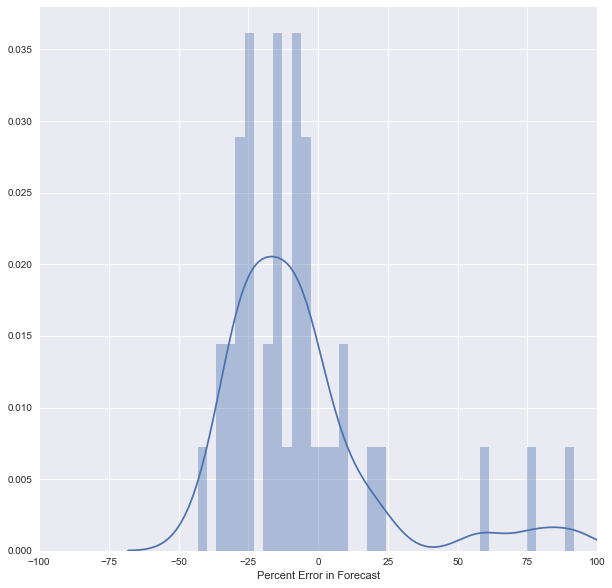

In [80]:
ax=sns.distplot(tct_lowrisk['PercentError'],bins=40,kde=True,axlabel='Percent Error in Forecast')
ax.figure.set_size_inches(10,10)
ax.set_xlim(-100,100)
ax.figure.savefig('tct_lowrisk.png')

In [77]:
tct_highrisk=error_method1[error_method1['ImprovementType']>1]
tct_highrisk.describe()

,AverageCount,AverageForecast,Error,PercentError,AbsPE,ImprovementType,Func_Class,Forecast_Method,Diff_Year,UnifiedImprovementType
count,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.0,201.000000,201.000000
mean,17301.241396,16404.861839,896.379557,8.233785,29.554335,11.268657,5.831841,1.0,20.143449,2.820896
std,17515.288208,16378.798674,7494.111072,52.706324,44.365130,2.346798,2.319788,0.0,243.626312,0.572504
min,130.000000,170.000000,-32112.500000,-77.566425,0.598802,2.000000,1.000000,1.0,-1979.000000,1.000000
25%,4900.000000,5010.000000,-1800.000000,-15.517241,8.230893,12.000000,3.400000,1.0,2.000000,3.000000
50%,11831.250000,13100.000000,-200.000000,-4.651163,16.666667,12.000000,8.000000,1.0,9.000000,3.000000
75%,24200.000000,20931.333333,2600.000000,18.052257,33.548387,12.000000,8.000000,1.0,19.000000,3.000000
max,135500.000000,148500.000000,28935.294118,351.764706,351.764706,12.000000,8.000000,1.0,2000.000000,3.000000


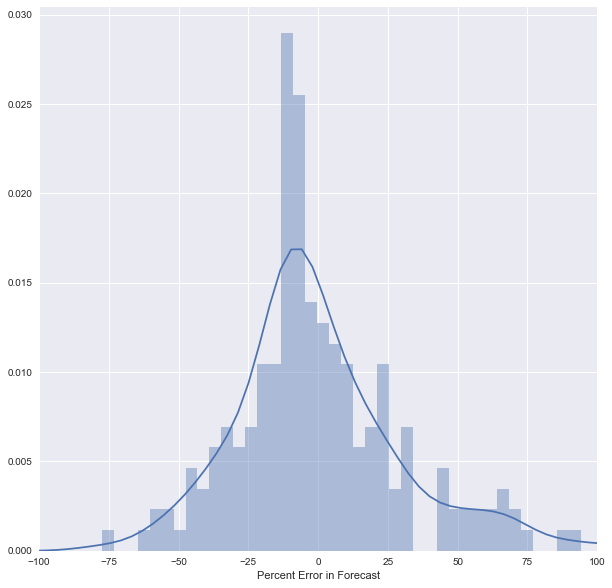

In [81]:
ax=sns.distplot(tct_highrisk['PercentError'],bins=100,kde=True,axlabel='Percent Error in Forecast')
ax.figure.set_size_inches(10,10)
ax.set_xlim(-100,100)
ax.figure.savefig('tct_highrisk.png')

I think the floating numbers are because some projects span over roads of different functional class and also they have different sort of improvement.

In [60]:
project_error2.groupby(project_error2['Forecast_Method']).count()

,AverageCount,AverageForecast,Error,PercentError,AbsPE,ImprovementType,Func_Class,Diff_Year,UnifiedImprovementType
Forecast_Method,,,,,,,,,
1.0,242,242,242,242,242,242,242,242,242
2.0,5,5,5,5,5,5,5,5,5
2.6,1,1,1,1,1,1,1,1,1
3.5,1,1,1,1,1,1,1,1,1
4.0,134,134,134,134,134,134,134,134,134
5.0,77,77,77,77,77,77,77,77,77
5.5,1,1,1,1,1,1,1,1,1
6.0,567,567,567,567,567,567,567,567,567


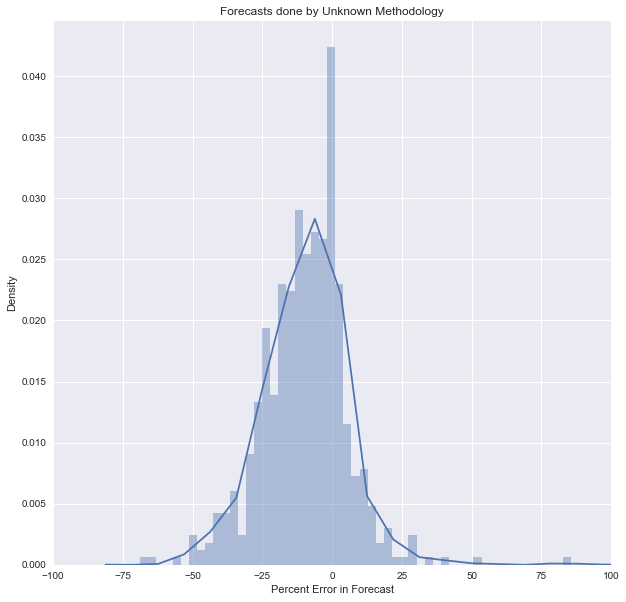

In [349]:
errortype3=project_error2[project_error2['Forecast_Method']==6]
ax=sns.distplot(errortype3['PercentError'],bins=400,kde=True,axlabel='Percent Error in Forecast')
ax.figure.set_size_inches(10,10)
ax.set_xlim(-100,100)  
ax.set_title("Forecasts done by Unknown Methodology")
ax.set_xlabel('Percent Error in Forecast')
ax.set_ylabel('Density')
plt.legend(loc='upper right')
plt.show()
#plt.text(25,0.025,'Total Number of Projects 688')
ax.text(25, 0.03, "Total Number of Projects 567", horizontalalignment='left', size='medium', color='black', weight='semibold')
ax.figure.savefig('Error for Unknown Method.png')

In [43]:
errortype3=project_error2[project_error2['Forecast_Method']==6]
errortype3['AbsPE'].describe()

count     567.000000
mean       16.147611
std        48.966040
min         0.000000
25%         4.186013
50%        10.962822
75%        19.970522
max      1096.781076
Name: AbsPE, dtype: float64

In [84]:
new.describe()

,AdjustedForecast,Count,ForecastMethodology,ForecastYear,ForecastYearType,FunctionalClass,ImprovementType,Length_miles,SegmentID,State,TollType,TrafficForecast,YearForecastProduced,Year_ofObservation,main_TrafficForecast_ProjectID,Error,PercentError,AbsPE
count,5090.000000,5090.000000,5090.000000,5090.000000,3523.0,5090.000000,5090.000000,2457.000000,994.000000,5090.000000,5090.000000,5090.000000,5086.000000,5090.000000,3523.000000,5090.000000,5090.000000,5090.000000
mean,24494.234813,25458.024558,3.182122,2004.071709,1.0,5.027505,7.513163,3.815395,1.523139,31.588802,1.010216,24492.393124,1960.064687,2004.075639,8054.451036,963.789745,12.456287,36.390462
std,23627.621950,24595.266560,2.280151,8.400994,0.0,2.644382,5.227044,61.916721,0.741496,13.026119,0.100567,23706.936142,263.514017,8.241776,1039.463796,12162.148801,94.827202,88.446944
min,-40029.000000,130.000000,1.000000,1975.000000,1.0,0.000000,1.000000,0.001000,1.000000,12.000000,1.000000,170.000000,0.000000,1975.000000,6231.000000,-118900.000000,-169.899323,0.000000
25%,8500.000000,7900.000000,1.000000,2000.000000,1.0,3.000000,1.000000,0.260000,1.000000,28.000000,1.000000,8500.000000,1982.000000,2000.000000,7139.500000,-3325.000000,-19.384955,8.004059
50%,18250.000000,17677.500000,1.000000,2007.000000,1.0,4.000000,12.000000,0.640000,1.000000,28.000000,1.000000,17920.000000,2003.000000,2008.000000,8064.000000,-389.000000,-3.969131,18.686815
75%,32616.875000,35500.000000,6.000000,2010.000000,1.0,8.000000,12.000000,2.606000,2.000000,41.000000,1.000000,32480.000000,2007.000000,2010.000000,9084.500000,2500.000000,16.388856,38.907590
max,179400.000000,172000.000000,6.000000,2017.000000,1.0,8.000000,12.000000,3064.000000,4.000000,58.000000,2.000000,179400.000000,2013.000000,2015.000000,9660.000000,148800.000000,2142.424242,2142.424242


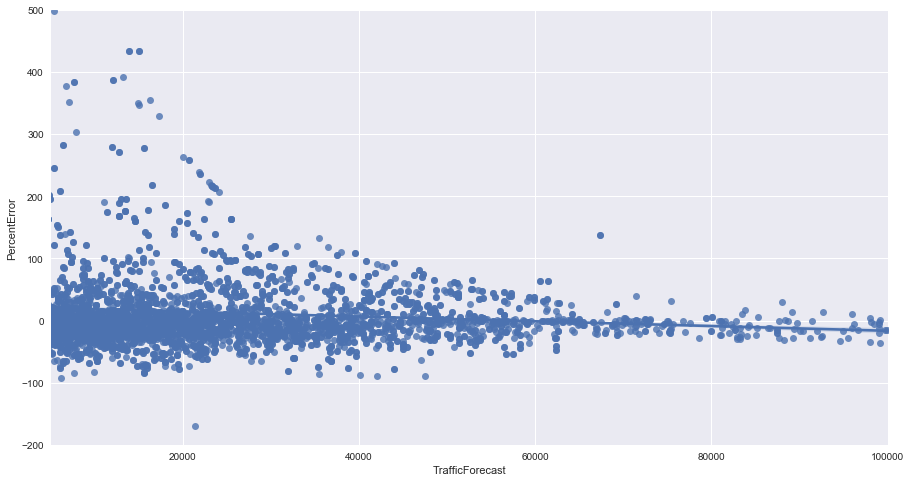

In [41]:
ax=sns.regplot(new['TrafficForecast'],new['PercentError'])
ax.figure.set_size_inches(15,8)
ax.set_xlim(5000,100000)
ax.set_ylim(-200,500)
ax.figure.savefig('scatterplottrafficforecast.png')

In [100]:
flatdata_adjusted['Error'].describe()

count      5118.000000
mean       1018.755334
std       12166.589541
min     -118900.000000
25%       -3300.000000
50%        -350.000000
75%        2600.000000
max      148800.000000
Name: Error, dtype: float64

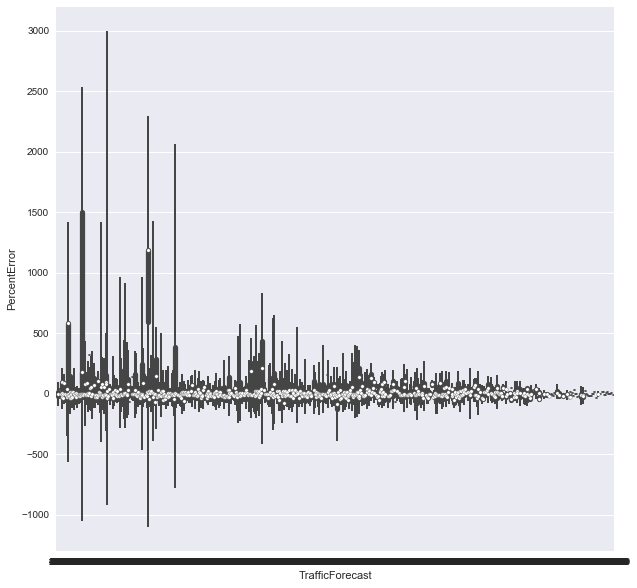

In [96]:
ax=sns.violinplot(x=new['TrafficForecast'], y=new['PercentError'])
ax.figure.set_size_inches(10,10)
#ax.set_xlim(5000,100000)
#ax.set_ylim(-200,500)

In [101]:
flatdata_adjusted=flatdata_adjusted.assign(AbsError=np.abs(flatdata_adjusted['Error']))
flatdata_adjusted

,AdjustedForecast,BriefDescription,Count,County,ForecastMethodology,ForecastYear,ForecastYearType,FunctionalClass,ImprovementType,InternalProjectID,Length_miles,SegmentDescription,SegmentID,State,TollType,TrafficForecast,YearForecastProduced,Year_ofObservation,main_ProjectInformation_ProjectID,main_TrafficForecast_ProjectID,Error,PercentError,AbsPE,AbsError
0,5300.0,NaN,3700,Washington,1,2010,1.0,3,12,1663,NaN,NaN,NaN,58,1,5300,2007.0,2010,58-6231-1663-,6231.0,-1600.0,-30.188679,30.188679,1600.0
1,7400.0,NaN,5500,Washington,1,2010,1.0,3,12,1663,NaN,NaN,NaN,58,1,7400,2007.0,2010,58-6232-1663-,6232.0,-1900.0,-25.675676,25.675676,1900.0
2,4150.0,NaN,2800,Washington,1,2010,1.0,3,12,1663,NaN,NaN,NaN,58,1,4150,2007.0,2010,58-6233-1663-,6233.0,-1350.0,-32.530120,32.530120,1350.0
3,3700.0,NaN,2500,Washington,1,2010,1.0,3,12,1663,NaN,NaN,NaN,58,1,3700,2007.0,2010,58-6234-1663-,6234.0,-1200.0,-32.432432,32.432432,1200.0
4,4500.0,NaN,3500,Washington,1,2010,1.0,3,12,1663,NaN,NaN,NaN,58,1,4500,2007.0,2010,58-6235-1663-,6235.0,-1000.0,-22.222222,22.222222,1000.0
5,18800.0,NaN,14000,Washington,1,2007,1.0,4,12,2015,NaN,NaN,NaN,58,1,18800,2005.0,2007,58-6236-2015-,6236.0,-4800.0,-25.531915,25.531915,4800.0
6,18200.0,NaN,14700,Washington,1,2007,1.0,4,12,2015,NaN,NaN,NaN,58,1,18200,2005.0,2007,58-6237-2015-,6237.0,-3500.0,-19.230769,19.230769,3500.0
7,19600.0,NaN,16900,Washington,1,2007,1.0,4,12,2015,NaN,NaN,NaN,58,1,19600,2005.0,2007,58-6238-2015-,6238.0,-2700.0,-13.775510,13.775510,2700.0
8,1300.0,NaN,1900,Washington,1,2007,1.0,0,12,2126,NaN,NaN,NaN,58,1,1300,2006.0,2007,58-6239-2126-,6239.0,600.0,46.153846,46.153846,600.0
9,1300.0,NaN,1000,Washington,1,2010,1.0,5,12,2486,NaN,NaN,NaN,58,1,1300,2007.0,2010,58-6240-2486-,6240.0,-300.0,-23.076923,23.076923,300.0


In [102]:
flatdata_adjusted['AbsError'].describe()

count      5118.000000
mean       6708.315265
std       10200.670475
min           0.000000
25%         975.250000
50%        3000.000000
75%        8411.250000
max      148800.000000
Name: AbsError, dtype: float64

(-200, 500)

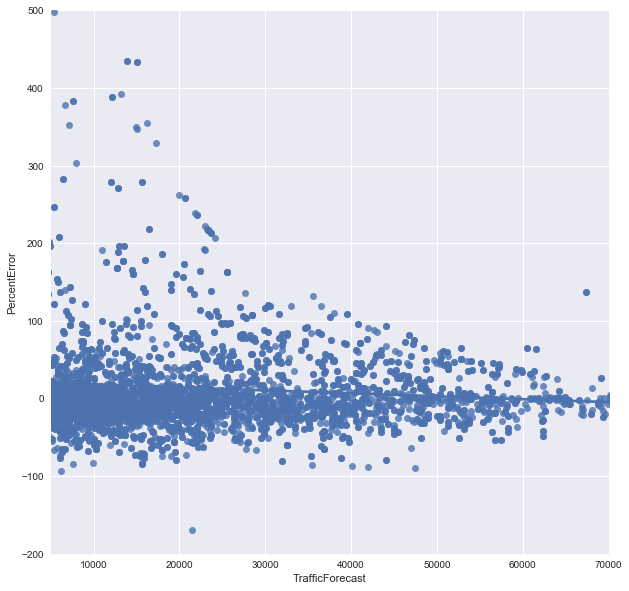

In [109]:
ax=sns.regplot(flatdata_adjusted['TrafficForecast'],flatdata_adjusted['PercentError'])
ax.figure.set_size_inches(10,10)
ax.set_xlim(5000,70000)
ax.set_ylim(-200,500)

In [114]:
nicolaisen=pd.read_csv('Nicolaisen.csv', encoding='latin1',)
nicolaisen

,InternalProjectID,Country,Section,Accuracy1,Main1,Count1,Yforecast,Ycount1,ForecastMethod
0,1,DK,New network total,-0.013412,565300.0,557718.0,2003.0,2009.0,4
1,2,DK,New network total,-0.035728,859700.0,828985.0,2002.0,NaN,4
2,3,DK,New network total,0.050435,57500.0,60400.0,2002.0,NaN,1
3,4,DK,New network total,0.029236,150500.0,154900.0,1997.0,NaN,1
4,5,DK,New project total,-0.129534,19300.0,16800.0,1997.0,2009.0,1
5,6,DK,New network total,0.464689,24100.0,35299.0,1995.0,NaN,5
6,7,DK,New network total,0.257143,10500.0,13200.0,1995.0,NaN,5
7,8,DK,New project total,-0.060619,9700.0,9112.0,1992.0,1998.0,1
8,9,DK,New project total,0.045323,31000.0,32405.0,1998.0,2010.0,4
9,10,DK,New network total,0.204816,62500.0,75301.0,1994.0,NaN,6


In [135]:
project_error2

,AverageCount,AverageForecast,Error,PercentError,AbsPE,ImprovementType,Func_Class,Forecast_Method,Diff_Year,UnifiedImprovementType
InternalProjectID,,,,,,,,,,
10914,67797.500000,69861.250000,-2063.750000,-2.954070,2.954070,11.000000,1.000000,6.0,1.000000,2
12343,99720.000000,99724.000000,-4.000000,-0.004011,0.004011,1.000000,1.000000,6.0,5.000000,1
12356,28800.000000,31001.000000,-2201.000000,-7.099771,7.099771,12.000000,1.000000,6.0,3.000000,3
13364,4610.000000,4910.000000,-300.000000,-6.109980,6.109980,1.000000,5.000000,6.0,1.000000,1
13486,53705.000000,60317.500000,-6612.500000,-10.962822,10.962822,3.000000,1.000000,6.0,5.000000,1
13624,580.000000,635.000000,-55.000000,-8.661417,8.661417,1.000000,6.000000,6.0,0.000000,1
14821,34445.000000,28621.750000,5823.250000,20.345541,20.345541,3.000000,4.000000,6.0,2.000000,1
16144,15556.000000,16568.736842,-1012.736842,-6.112336,6.112336,2.000000,3.000000,6.0,6.000000,1
16514,54630.000000,58143.333333,-3513.333333,-6.042539,6.042539,11.000000,1.000000,6.0,6.000000,2


In [116]:
nicolaisen=nicolaisen[nicolaisen['Section']=='New project total']

In [117]:
nicolaisen=nicolaisen.assign(AbsPE=np.abs(nicolaisen['Accuracy1'])*100)
nicolaisen

,InternalProjectID,Country,Section,Accuracy1,Main1,Count1,Yforecast,Ycount1,ForecastMethod,AbsPE
4,5,DK,New project total,-0.129534,19300.0,16800.0,1997.0,2009.0,1,12.953368
7,8,DK,New project total,-0.060619,9700.0,9112.0,1992.0,1998.0,1,6.061856
8,9,DK,New project total,0.045323,31000.0,32405.0,1998.0,2010.0,4,4.532258
10,11,DK,New project total,-0.018868,15900.0,15600.0,1998.0,2007.0,1,1.886793
13,14,DK,New project total,0.209717,45900.0,55526.0,1990.0,2005.0,6,20.971678
14,15,DK,New project total,0.021189,67300.0,68726.0,1990.0,2002.0,6,2.118871
17,18,DK,New project total,0.763721,4300.0,7584.0,1993.0,1998.0,6,76.372093
21,22,DK,New project total,0.106667,7500.0,8300.0,1990.0,2001.0,6,10.666667
22,23,DK,New project total,1.237959,9800.0,21932.0,1987.0,2000.0,6,123.795918
24,25,DK,New project total,-0.188571,17500.0,14200.0,1961.0,1971.0,6,18.857143


In [118]:
nicolaisen=nicolaisen.drop(['Country','Section'],axis=1)

In [119]:
nicolaisen=nicolaisen.rename(index=str, 
                             columns={"Accuracy1": "Error", "Main1": "AverageForecast", 'Count1':'AverageCount',
                                      "Yforecast":
                                     })
nicolaisen

,InternalProjectID,Error,AverageForecast,AverageCount,Yforecast,Ycount1,ForecastMethod,AbsPE
4,5,-0.129534,19300.0,16800.0,1997.0,2009.0,1,12.953368
7,8,-0.060619,9700.0,9112.0,1992.0,1998.0,1,6.061856
8,9,0.045323,31000.0,32405.0,1998.0,2010.0,4,4.532258
10,11,-0.018868,15900.0,15600.0,1998.0,2007.0,1,1.886793
13,14,0.209717,45900.0,55526.0,1990.0,2005.0,6,20.971678
14,15,0.021189,67300.0,68726.0,1990.0,2002.0,6,2.118871
17,18,0.763721,4300.0,7584.0,1993.0,1998.0,6,76.372093
21,22,0.106667,7500.0,8300.0,1990.0,2001.0,6,10.666667
22,23,1.237959,9800.0,21932.0,1987.0,2000.0,6,123.795918
24,25,-0.188571,17500.0,14200.0,1961.0,1971.0,6,18.857143


In [120]:
nicolaisen=nicolaisen.assign(PercentError=100*nicolaisen['Error'])
nicolaisen

,InternalProjectID,Error,AverageForecast,AverageCount,Yforecast,Ycount1,ForecastMethod,AbsPE,PercentError
4,5,-0.129534,19300.0,16800.0,1997.0,2009.0,1,12.953368,-12.953368
7,8,-0.060619,9700.0,9112.0,1992.0,1998.0,1,6.061856,-6.061856
8,9,0.045323,31000.0,32405.0,1998.0,2010.0,4,4.532258,4.532258
10,11,-0.018868,15900.0,15600.0,1998.0,2007.0,1,1.886793,-1.886793
13,14,0.209717,45900.0,55526.0,1990.0,2005.0,6,20.971678,20.971678
14,15,0.021189,67300.0,68726.0,1990.0,2002.0,6,2.118871,2.118871
17,18,0.763721,4300.0,7584.0,1993.0,1998.0,6,76.372093,76.372093
21,22,0.106667,7500.0,8300.0,1990.0,2001.0,6,10.666667,10.666667
22,23,1.237959,9800.0,21932.0,1987.0,2000.0,6,123.795918,123.795918
24,25,-0.188571,17500.0,14200.0,1961.0,1971.0,6,18.857143,-18.857143


In [121]:
nicolaisen=nicolaisen.assign(UnifiedImprovementType=6.0)
nicolaisen

,InternalProjectID,Error,AverageForecast,AverageCount,Yforecast,Ycount1,ForecastMethod,AbsPE,PercentError,UnifiedImprovementType
4,5,-0.129534,19300.0,16800.0,1997.0,2009.0,1,12.953368,-12.953368,6.0
7,8,-0.060619,9700.0,9112.0,1992.0,1998.0,1,6.061856,-6.061856,6.0
8,9,0.045323,31000.0,32405.0,1998.0,2010.0,4,4.532258,4.532258,6.0
10,11,-0.018868,15900.0,15600.0,1998.0,2007.0,1,1.886793,-1.886793,6.0
13,14,0.209717,45900.0,55526.0,1990.0,2005.0,6,20.971678,20.971678,6.0
14,15,0.021189,67300.0,68726.0,1990.0,2002.0,6,2.118871,2.118871,6.0
17,18,0.763721,4300.0,7584.0,1993.0,1998.0,6,76.372093,76.372093,6.0
21,22,0.106667,7500.0,8300.0,1990.0,2001.0,6,10.666667,10.666667,6.0
22,23,1.237959,9800.0,21932.0,1987.0,2000.0,6,123.795918,123.795918,6.0
24,25,-0.188571,17500.0,14200.0,1961.0,1971.0,6,18.857143,-18.857143,6.0


In [ ]:
nicolaisen=nicolaisen.assign(Diff_Year=nicolaisen[''])
nicolaisen

In [136]:
project_error2

,AverageCount,AverageForecast,Error,PercentError,AbsPE,ImprovementType,Func_Class,Forecast_Method,Diff_Year,UnifiedImprovementType
InternalProjectID,,,,,,,,,,
10914,67797.500000,69861.250000,-2063.750000,-2.954070,2.954070,11.000000,1.000000,6.0,1.000000,2
12343,99720.000000,99724.000000,-4.000000,-0.004011,0.004011,1.000000,1.000000,6.0,5.000000,1
12356,28800.000000,31001.000000,-2201.000000,-7.099771,7.099771,12.000000,1.000000,6.0,3.000000,3
13364,4610.000000,4910.000000,-300.000000,-6.109980,6.109980,1.000000,5.000000,6.0,1.000000,1
13486,53705.000000,60317.500000,-6612.500000,-10.962822,10.962822,3.000000,1.000000,6.0,5.000000,1
13624,580.000000,635.000000,-55.000000,-8.661417,8.661417,1.000000,6.000000,6.0,0.000000,1
14821,34445.000000,28621.750000,5823.250000,20.345541,20.345541,3.000000,4.000000,6.0,2.000000,1
16144,15556.000000,16568.736842,-1012.736842,-6.112336,6.112336,2.000000,3.000000,6.0,6.000000,1
16514,54630.000000,58143.333333,-3513.333333,-6.042539,6.042539,11.000000,1.000000,6.0,6.000000,2


In [141]:
nicolaisen=nicolaisen.drop('Yforecast',axis=1)
nicolaisen

,AverageForecast,AverageCount,Ycount1,ForecastMethod,AbsPE,PercentError,UnifiedImprovementType
InternalProjectID,,,,,,,
5,19300.0,16800.0,2009.0,1,12.953368,-12.953368,6
8,9700.0,9112.0,1998.0,1,6.061856,-6.061856,6
9,31000.0,32405.0,2010.0,4,4.532258,4.532258,6
11,15900.0,15600.0,2007.0,1,1.886792,-1.886792,6
14,45900.0,55526.0,2005.0,6,20.971678,20.971678,6
15,67300.0,68726.0,2002.0,6,2.118871,2.118871,6
18,4300.0,7584.0,1998.0,6,76.372093,76.372093,6
22,7500.0,8300.0,2001.0,6,10.666667,10.666667,6
23,9800.0,21932.0,2000.0,6,123.795918,123.795918,6


In [142]:
nicolaisen=nicolaisen.drop('Ycount1',axis=1)
nicolaisen

,AverageForecast,AverageCount,ForecastMethod,AbsPE,PercentError,UnifiedImprovementType
InternalProjectID,,,,,,
5,19300.0,16800.0,1,12.953368,-12.953368,6
8,9700.0,9112.0,1,6.061856,-6.061856,6
9,31000.0,32405.0,4,4.532258,4.532258,6
11,15900.0,15600.0,1,1.886792,-1.886792,6
14,45900.0,55526.0,6,20.971678,20.971678,6
15,67300.0,68726.0,6,2.118871,2.118871,6
18,4300.0,7584.0,6,76.372093,76.372093,6
22,7500.0,8300.0,6,10.666667,10.666667,6
23,9800.0,21932.0,6,123.795918,123.795918,6


In [127]:
project_error2

,AverageCount,AverageForecast,Error,PercentError,AbsPE,ImprovementType,Func_Class,Forecast_Method,Diff_Year,UnifiedImprovementType
InternalProjectID,,,,,,,,,,
10914,67797.500000,69861.250000,-2063.750000,-2.954070,2.954070,11.000000,1.000000,6.0,1.000000,2
12343,99720.000000,99724.000000,-4.000000,-0.004011,0.004011,1.000000,1.000000,6.0,5.000000,1
12356,28800.000000,31001.000000,-2201.000000,-7.099771,7.099771,12.000000,1.000000,6.0,3.000000,3
13364,4610.000000,4910.000000,-300.000000,-6.109980,6.109980,1.000000,5.000000,6.0,1.000000,1
13486,53705.000000,60317.500000,-6612.500000,-10.962822,10.962822,3.000000,1.000000,6.0,5.000000,1
13624,580.000000,635.000000,-55.000000,-8.661417,8.661417,1.000000,6.000000,6.0,0.000000,1
14821,34445.000000,28621.750000,5823.250000,20.345541,20.345541,3.000000,4.000000,6.0,2.000000,1
16144,15556.000000,16568.736842,-1012.736842,-6.112336,6.112336,2.000000,3.000000,6.0,6.000000,1
16514,54630.000000,58143.333333,-3513.333333,-6.042539,6.042539,11.000000,1.000000,6.0,6.000000,2


In [130]:
nicolaisen=pd.read_csv('nicolaisen.csv',index_col='InternalProjectID')

In [131]:
nicolaisen

,AverageForecast,AverageCount,Yforecast,Ycount1,ForecastMethod,AbsPE,PercentError,UnifiedImprovementType
InternalProjectID,,,,,,,,
5,19300.0,16800.0,1997.0,2009.0,1,12.953368,-12.953368,6
8,9700.0,9112.0,1992.0,1998.0,1,6.061856,-6.061856,6
9,31000.0,32405.0,1998.0,2010.0,4,4.532258,4.532258,6
11,15900.0,15600.0,1998.0,2007.0,1,1.886792,-1.886792,6
14,45900.0,55526.0,1990.0,2005.0,6,20.971678,20.971678,6
15,67300.0,68726.0,1990.0,2002.0,6,2.118871,2.118871,6
18,4300.0,7584.0,1993.0,1998.0,6,76.372093,76.372093,6
22,7500.0,8300.0,1990.0,2001.0,6,10.666667,10.666667,6
23,9800.0,21932.0,1987.0,2000.0,6,123.795918,123.795918,6


In [143]:
frames = [project_error2,nicolaisen]
result = pd.concat(frames)
result

,AbsPE,AverageCount,AverageForecast,Diff_Year,Error,ForecastMethod,Forecast_Method,Func_Class,ImprovementType,PercentError,UnifiedImprovementType
InternalProjectID,,,,,,,,,,,
10914,2.954070,67797.500000,69861.250000,1.0,-2063.750000,NaN,6.0,1.000000,11.0,-2.954070,2
12343,0.004011,99720.000000,99724.000000,5.0,-4.000000,NaN,6.0,1.000000,1.0,-0.004011,1
12356,7.099771,28800.000000,31001.000000,3.0,-2201.000000,NaN,6.0,1.000000,12.0,-7.099771,3
13364,6.109980,4610.000000,4910.000000,1.0,-300.000000,NaN,6.0,5.000000,1.0,-6.109980,1
13486,10.962822,53705.000000,60317.500000,5.0,-6612.500000,NaN,6.0,1.000000,3.0,-10.962822,1
13624,8.661417,580.000000,635.000000,0.0,-55.000000,NaN,6.0,6.000000,1.0,-8.661417,1
14821,20.345541,34445.000000,28621.750000,2.0,5823.250000,NaN,6.0,4.000000,3.0,20.345541,1
16144,6.112336,15556.000000,16568.736842,6.0,-1012.736842,NaN,6.0,3.000000,2.0,-6.112336,1
16514,6.042539,54630.000000,58143.333333,6.0,-3513.333333,NaN,6.0,1.000000,11.0,-6.042539,2


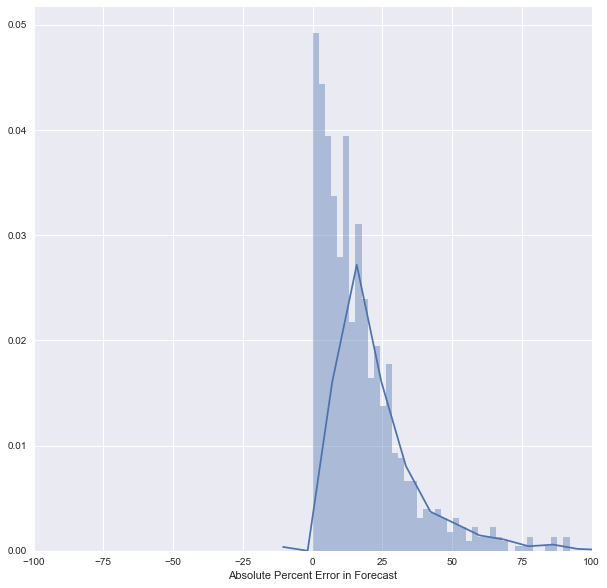

In [144]:
ax=sns.distplot(project_error2['AbsPE'],bins=500,kde=True,axlabel='Absolute Percent Error in Forecast')
ax.figure.set_size_inches(10,10)
ax.set_xlim(-100,100)
ax.figure.savefig('ProjectLevel PE2.png')

In [145]:
result

,AbsPE,AverageCount,AverageForecast,Diff_Year,Error,ForecastMethod,Forecast_Method,Func_Class,ImprovementType,PercentError,UnifiedImprovementType
InternalProjectID,,,,,,,,,,,
10914,2.954070,67797.500000,69861.250000,1.0,-2063.750000,NaN,6.0,1.000000,11.0,-2.954070,2
12343,0.004011,99720.000000,99724.000000,5.0,-4.000000,NaN,6.0,1.000000,1.0,-0.004011,1
12356,7.099771,28800.000000,31001.000000,3.0,-2201.000000,NaN,6.0,1.000000,12.0,-7.099771,3
13364,6.109980,4610.000000,4910.000000,1.0,-300.000000,NaN,6.0,5.000000,1.0,-6.109980,1
13486,10.962822,53705.000000,60317.500000,5.0,-6612.500000,NaN,6.0,1.000000,3.0,-10.962822,1
13624,8.661417,580.000000,635.000000,0.0,-55.000000,NaN,6.0,6.000000,1.0,-8.661417,1
14821,20.345541,34445.000000,28621.750000,2.0,5823.250000,NaN,6.0,4.000000,3.0,20.345541,1
16144,6.112336,15556.000000,16568.736842,6.0,-1012.736842,NaN,6.0,3.000000,2.0,-6.112336,1
16514,6.042539,54630.000000,58143.333333,6.0,-3513.333333,NaN,6.0,1.000000,11.0,-6.042539,2


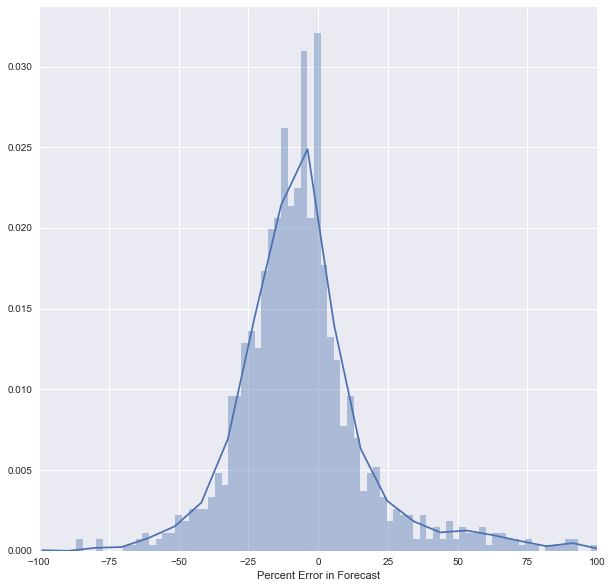

In [146]:
ax=sns.distplot(result['PercentError'],bins=500,kde=True,axlabel='Percent Error in Forecast')
ax.figure.set_size_inches(10,10)
ax.set_xlim(-100,100)
ax.figure.savefig('ProjectLevel PE2.png')

In [151]:
result['AbsPE'].describe()

count    1146.000000
mean       20.691859
std        42.919968
min         0.000000
25%         5.583533
50%        12.936415
75%        24.295728
max      1096.781076
Name: AbsPE, dtype: float64

In [160]:
result[result['AbsPE']>300]

,AbsPE,AverageCount,AverageForecast,Diff_Year,Error,ForecastMethod,Forecast_Method,Func_Class,ImprovementType,PercentError,UnifiedImprovementType
InternalProjectID,,,,,,,,,,,
411787-1,329.722471,160000.000000,37233.333333,2.0,122766.666667,NaN,5.0,1.0,1.0,329.722471,1
84934,320.625000,13460.000000,3200.000000,1.0,10260.000000,NaN,6.0,3.0,1.0,320.625000,1
88000,1096.781076,129013.000000,10780.000000,1.0,118233.000000,NaN,6.0,1.0,1.0,1096.781076,1
SPAR-202,351.764706,32000.000000,7083.333333,22.0,24916.666667,NaN,1.0,8.0,12.0,351.764706,3
TAU 3077,326.708633,7908.333333,1853.333333,20.0,6055.000000,NaN,1.0,8.0,12.0,326.708633,3


In [161]:
tct_highrisk['AbsPE'].describe()

count    201.000000
mean      29.554335
std       44.365130
min        0.598802
25%        8.230893
50%       16.666667
75%       33.548387
max      351.764706
Name: AbsPE, dtype: float64